Mount Google Drive:

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
tf.test.gpu_device_name()


'/device:GPU:0'

In [7]:
%cd '/content/drive/MyDrive/Colab Notebooks/phase4 public'

/content/drive/.shortcut-targets-by-id/1olR9djsPqRY8dxn01k2qeMnqfOfqWRQE/phase4 public


In [8]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.functional import F
import numpy as np
from tqdm import trange
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from utils import get_data_loaders


In [6]:
!ls

'CI - Spring_2023 - phase4.pdf'   exploring_data.py   utils.py
 data				  __pycache__
 dataloader_demo.ipynb		  triplet_loss.py


In [9]:
full_dataloaders, _ = get_data_loaders(
    {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz',
     'test': './data/12000_test_mnistmnistmsvhnsynusps.npz',
     'missing_test': './data/12000_test_mnistmnistmsvhnsynusps.npz'
     },
    batch_size= 64)

datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz', 'missing_test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
reading ./data/12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600


In [ ]:
#part1

In [ ]:
#Base Model

Epoch 1/10 - Loss: 0.8795 - Train Accuracy: 0.7380 - Test Accuracy: 0.7983
Epoch 2/10 - Loss: 0.6285 - Train Accuracy: 0.8236 - Test Accuracy: 0.8189
Epoch 3/10 - Loss: 0.5709 - Train Accuracy: 0.8441 - Test Accuracy: 0.8223
Epoch 4/10 - Loss: 0.5302 - Train Accuracy: 0.8553 - Test Accuracy: 0.8204
Epoch 5/10 - Loss: 0.5091 - Train Accuracy: 0.8639 - Test Accuracy: 0.8116
Epoch 6/10 - Loss: 0.4851 - Train Accuracy: 0.8716 - Test Accuracy: 0.8254
Epoch 7/10 - Loss: 0.4768 - Train Accuracy: 0.8757 - Test Accuracy: 0.8208
Epoch 8/10 - Loss: 0.4474 - Train Accuracy: 0.8818 - Test Accuracy: 0.8271
Epoch 9/10 - Loss: 0.4435 - Train Accuracy: 0.8871 - Test Accuracy: 0.8233
Epoch 10/10 - Loss: 0.4386 - Train Accuracy: 0.8891 - Test Accuracy: 0.8202


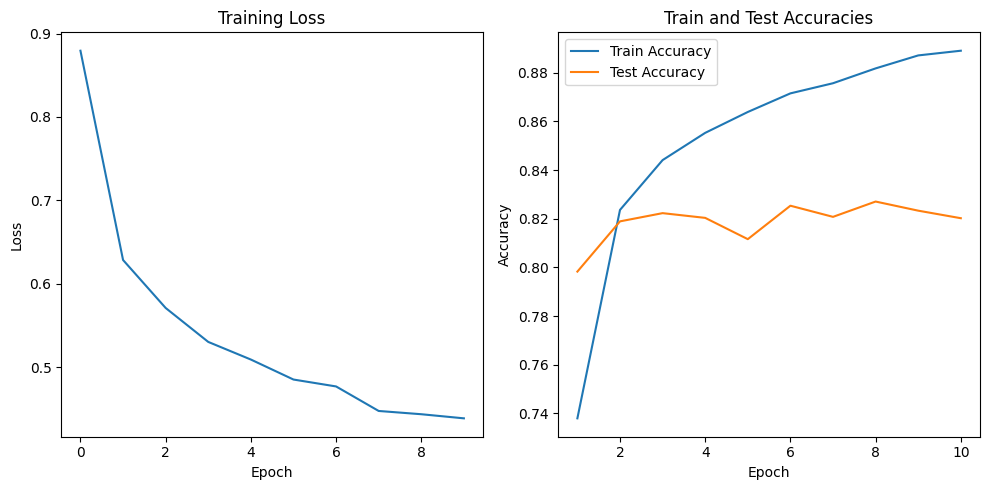

In [8]:
class DigitModel(nn.Module):
    def __init__(self, num_features):
        super(DigitModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.fc = nn.Linear(32 * 32 * 32 + num_features, 128)
        self.activation = nn.ReLU()
        self.output_layer = nn.Linear(128, 10)

    def forward(self, images, features):
        cnn_output = self.cnn(images)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)
        combined = torch.cat((cnn_output, features), dim=1)
        fc_output = self.fc(combined)
        fc_output = self.activation(fc_output)
        output = self.output_layer(fc_output)
        return output

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, features, _, digit_labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        digit_labels = digit_labels.to(device)

        optimizer.zero_grad()
        output = model(images, features)
        loss = criterion(output, digit_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

    accuracy = correct / total
    return running_loss / len(train_loader), accuracy


def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, features, _, digit_labels in test_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)

            output = model(images, features)
            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()
    accuracy = correct / total
    return accuracy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DigitModel(num_features=256).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']

num_epochs = 10
train_losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    test_accuracy = evaluate(model, test_loader, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Test Accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")

plt.subplot(1, 2, 2)
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracies")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Add a Layer

Epoch 1/10 - Loss: 0.9598 - Train Accuracy: 0.7300 - Test Accuracy: 0.7885
Epoch 2/10 - Loss: 0.6205 - Train Accuracy: 0.8251 - Test Accuracy: 0.7732
Epoch 3/10 - Loss: 0.5510 - Train Accuracy: 0.8466 - Test Accuracy: 0.8194
Epoch 4/10 - Loss: 0.5281 - Train Accuracy: 0.8577 - Test Accuracy: 0.8186
Epoch 5/10 - Loss: 0.5013 - Train Accuracy: 0.8662 - Test Accuracy: 0.8210
Epoch 6/10 - Loss: 0.4842 - Train Accuracy: 0.8714 - Test Accuracy: 0.8229
Epoch 7/10 - Loss: 0.4780 - Train Accuracy: 0.8765 - Test Accuracy: 0.8245
Epoch 8/10 - Loss: 0.4583 - Train Accuracy: 0.8834 - Test Accuracy: 0.8234
Epoch 9/10 - Loss: 0.4558 - Train Accuracy: 0.8861 - Test Accuracy: 0.8229
Epoch 10/10 - Loss: 0.4364 - Train Accuracy: 0.8915 - Test Accuracy: 0.8248


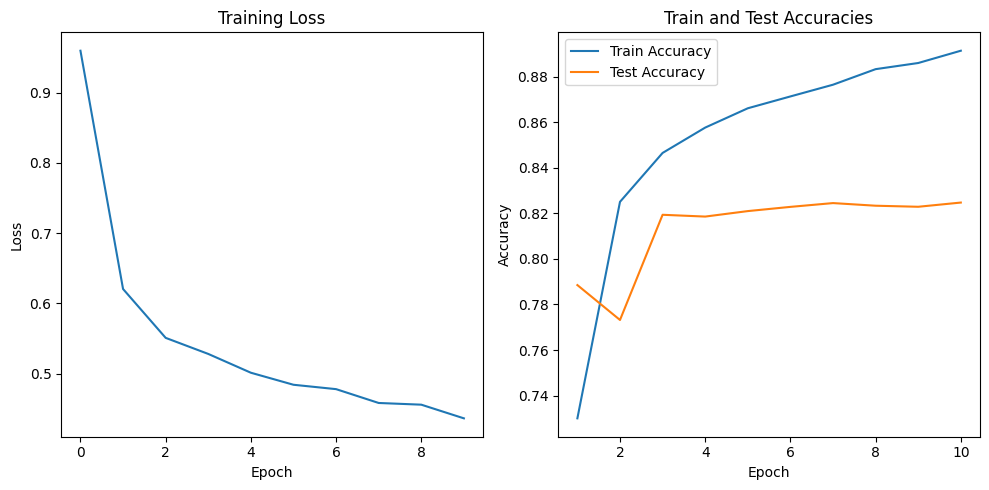

In [9]:
class DigitModel(nn.Module):
    def __init__(self, num_features):
        super(DigitModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.fc = nn.Linear(64 * 32 * 32 + num_features, 128)
        self.activation = nn.ReLU()
        self.output_layer = nn.Linear(128, 10)

    def forward(self, images, features):
        cnn_output = self.cnn(images)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)
        combined = torch.cat((cnn_output, features), dim=1)
        fc_output = self.fc(combined)
        fc_output = self.activation(fc_output)
        output = self.output_layer(fc_output)
        return output

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, features, _, digit_labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        digit_labels = digit_labels.to(device)

        optimizer.zero_grad()
        output = model(images, features)
        loss = criterion(output, digit_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

    accuracy = correct / total
    return running_loss / len(train_loader), accuracy


def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, features, _, digit_labels in test_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)

            output = model(images, features)
            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()
    accuracy = correct / total
    return accuracy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DigitModel(num_features=256).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']

num_epochs = 10
train_losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    test_accuracy = evaluate(model, test_loader, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Test Accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")

plt.subplot(1, 2, 2)
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracies")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# add max pooling

Epoch 1/10 - Loss: 0.8638 - Train Accuracy: 0.7384 - Test Accuracy: 0.7968
Epoch 2/10 - Loss: 0.6279 - Train Accuracy: 0.8224 - Test Accuracy: 0.8041
Epoch 3/10 - Loss: 0.5567 - Train Accuracy: 0.8404 - Test Accuracy: 0.8124
Epoch 4/10 - Loss: 0.5238 - Train Accuracy: 0.8527 - Test Accuracy: 0.8103
Epoch 5/10 - Loss: 0.4980 - Train Accuracy: 0.8606 - Test Accuracy: 0.8194
Epoch 6/10 - Loss: 0.4856 - Train Accuracy: 0.8653 - Test Accuracy: 0.8118
Epoch 7/10 - Loss: 0.4490 - Train Accuracy: 0.8752 - Test Accuracy: 0.8188
Epoch 8/10 - Loss: 0.4522 - Train Accuracy: 0.8775 - Test Accuracy: 0.8186
Epoch 9/10 - Loss: 0.4238 - Train Accuracy: 0.8824 - Test Accuracy: 0.8175
Epoch 10/10 - Loss: 0.4312 - Train Accuracy: 0.8843 - Test Accuracy: 0.8165


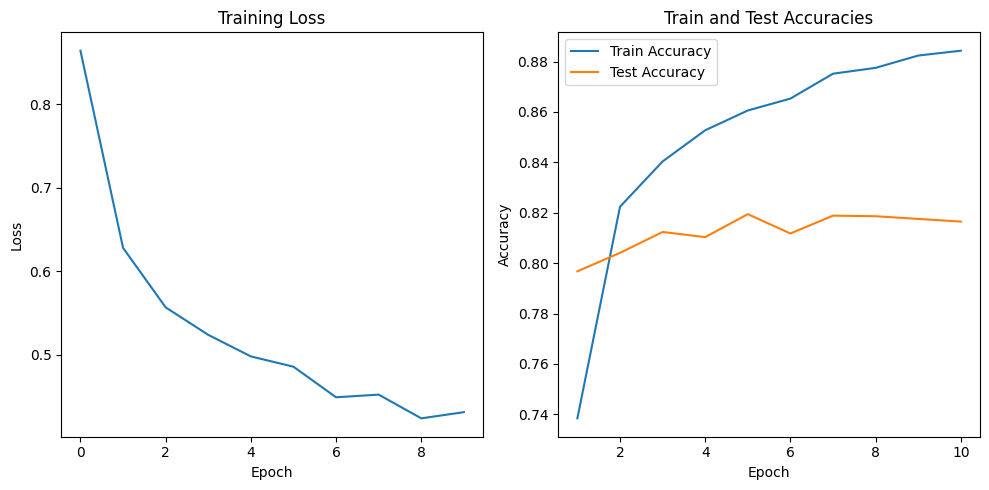

In [ ]:
class DigitModel(nn.Module):
    def __init__(self, num_features):
        super(DigitModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(64 * 4 * 4 + num_features, 128)
        self.activation = nn.ReLU()
        self.output_layer = nn.Linear(128, 10)

    def forward(self, images, features):
        cnn_output = self.cnn(images)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)
        combined = torch.cat((cnn_output, features), dim=1)
        fc_output = self.fc(combined)
        fc_output = self.activation(fc_output)
        output = self.output_layer(fc_output)
        return output

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, features, _, digit_labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        digit_labels = digit_labels.to(device)

        optimizer.zero_grad()
        output = model(images, features)
        loss = criterion(output, digit_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

    accuracy = correct / total
    return running_loss / len(train_loader), accuracy


def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, features, _, digit_labels in test_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)

            output = model(images, features)
            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()
    accuracy = correct / total
    return accuracy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DigitModel(num_features=256).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']

num_epochs = 10
train_losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    test_accuracy = evaluate(model, test_loader, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Test Accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")

plt.subplot(1, 2, 2)
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracies")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# add 3 con2d layer

Epoch 1/10 - Loss: 0.9316 - Train Accuracy: 0.7382 - Test Accuracy: 0.8035
Epoch 2/10 - Loss: 0.6146 - Train Accuracy: 0.8236 - Test Accuracy: 0.8155
Epoch 3/10 - Loss: 0.5580 - Train Accuracy: 0.8458 - Test Accuracy: 0.8195
Epoch 4/10 - Loss: 0.5350 - Train Accuracy: 0.8556 - Test Accuracy: 0.8266
Epoch 5/10 - Loss: 0.5134 - Train Accuracy: 0.8637 - Test Accuracy: 0.8151
Epoch 6/10 - Loss: 0.4950 - Train Accuracy: 0.8703 - Test Accuracy: 0.8262
Epoch 7/10 - Loss: 0.4893 - Train Accuracy: 0.8728 - Test Accuracy: 0.8161
Epoch 8/10 - Loss: 0.4561 - Train Accuracy: 0.8823 - Test Accuracy: 0.8213
Epoch 9/10 - Loss: 0.4472 - Train Accuracy: 0.8857 - Test Accuracy: 0.8229
Epoch 10/10 - Loss: 0.4347 - Train Accuracy: 0.8914 - Test Accuracy: 0.8200


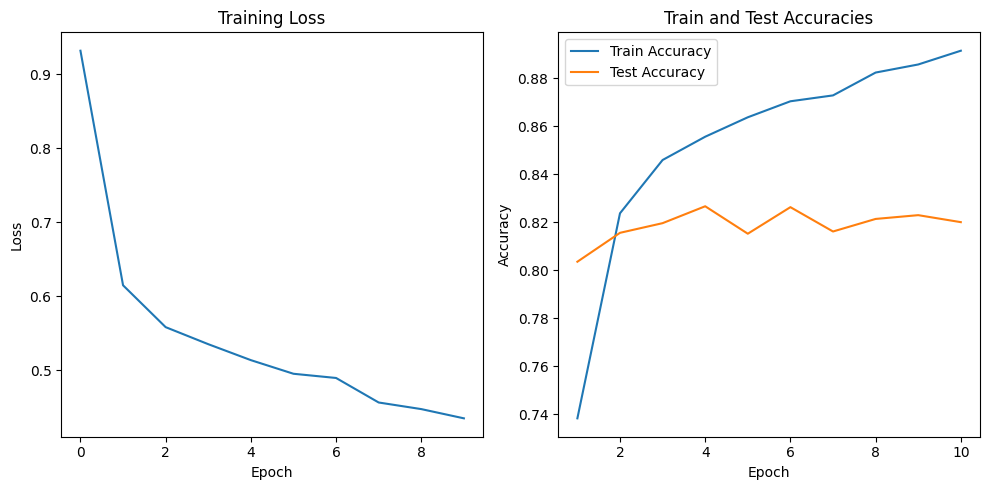

In [10]:
class DigitModel(nn.Module):
    def __init__(self, num_features):
        super(DigitModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(512 * 4 * 4 + num_features, 128)
        self.activation = nn.ReLU()
        self.output_layer = nn.Linear(128, 10)

    def forward(self, images, features):
        cnn_output = self.cnn(images)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)
        combined = torch.cat((cnn_output, features), dim=1)
        fc_output = self.fc(combined)
        fc_output = self.activation(fc_output)
        output = self.output_layer(fc_output)
        return output

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, features, _, digit_labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        digit_labels = digit_labels.to(device)

        optimizer.zero_grad()
        output = model(images, features)
        loss = criterion(output, digit_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

    accuracy = correct / total
    return running_loss / len(train_loader), accuracy


def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, features, _, digit_labels in test_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)

            output = model(images, features)
            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()
    accuracy = correct / total
    return accuracy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DigitModel(num_features=256).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']

num_epochs = 10
train_losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    test_accuracy = evaluate(model, test_loader, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Test Accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")

plt.subplot(1, 2, 2)
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracies")
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# remove some maxpooling

Epoch 1/10 - Loss: 0.9572 - Train Accuracy: 0.7318 - Test Accuracy: 0.8045
Epoch 2/10 - Loss: 0.6169 - Train Accuracy: 0.8249 - Test Accuracy: 0.8116
Epoch 3/10 - Loss: 0.5616 - Train Accuracy: 0.8448 - Test Accuracy: 0.8109
Epoch 4/10 - Loss: 0.5344 - Train Accuracy: 0.8560 - Test Accuracy: 0.8231
Epoch 5/10 - Loss: 0.5087 - Train Accuracy: 0.8648 - Test Accuracy: 0.8111
Epoch 6/10 - Loss: 0.4914 - Train Accuracy: 0.8710 - Test Accuracy: 0.8213
Epoch 7/10 - Loss: 0.4876 - Train Accuracy: 0.8724 - Test Accuracy: 0.8207
Epoch 8/10 - Loss: 0.4585 - Train Accuracy: 0.8807 - Test Accuracy: 0.8254
Epoch 9/10 - Loss: 0.4573 - Train Accuracy: 0.8860 - Test Accuracy: 0.8237
Epoch 10/10 - Loss: 0.4617 - Train Accuracy: 0.8882 - Test Accuracy: 0.8281


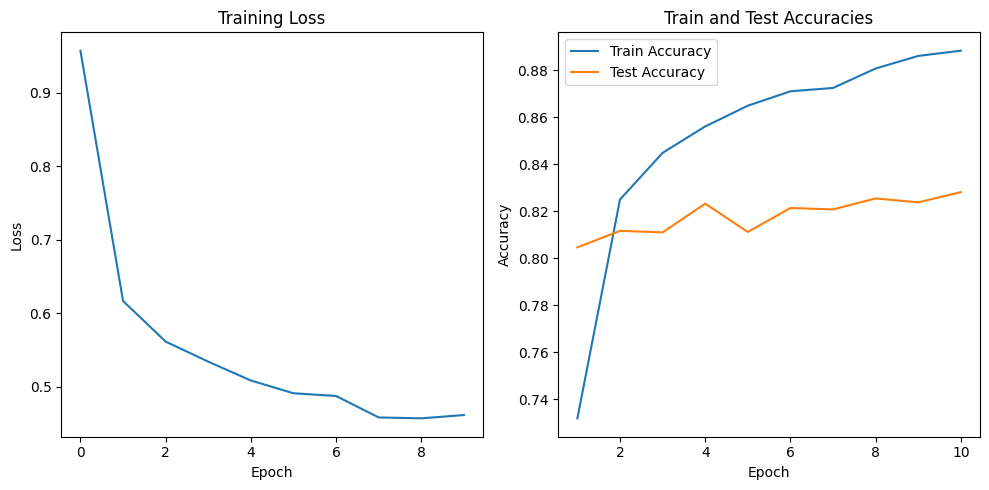

In [18]:
class DigitModel(nn.Module):
    def __init__(self, num_features):
        super(DigitModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.fc = nn.Linear(512 * 4 * 4 + num_features, 128)
        self.activation = nn.ReLU()
        self.output_layer = nn.Linear(128, 10)

    def forward(self, images, features):
        cnn_output = self.cnn(images)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)
        combined = torch.cat((cnn_output, features), dim=1)
        fc_output = self.fc(combined)
        fc_output = self.activation(fc_output)
        output = self.output_layer(fc_output)
        return output



def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, features, _, digit_labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        digit_labels = digit_labels.to(device)

        optimizer.zero_grad()
        output = model(images, features)
        loss = criterion(output, digit_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

    accuracy = correct / total
    return running_loss / len(train_loader), accuracy


def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, features, _, digit_labels in test_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)

            output = model(images, features)
            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()
    accuracy = correct / total
    return accuracy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DigitModel(num_features=256).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']

num_epochs = 10
train_losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    test_accuracy = evaluate(model, test_loader, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Test Accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")

plt.subplot(1, 2, 2)
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracies")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Batch_Size and Learning_Rate Tuning

datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
reading ./data/12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
reading ./data/12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
reading ./data/12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading ./data/12000_test_mnistmnistmsv

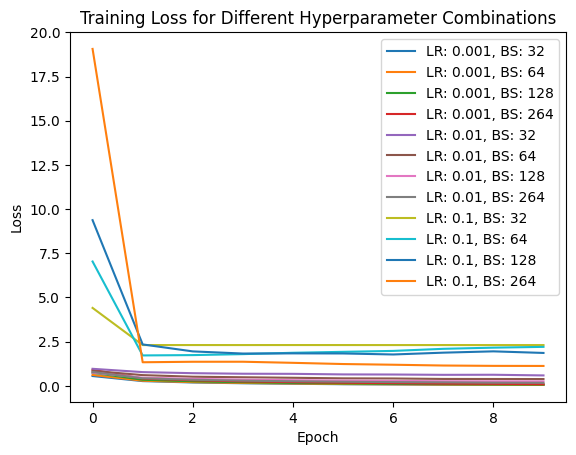


Best Test Accuracy: 0.9269
Best Learning Rate: 0.001, Best Batch Size: 32


In [ ]:
class DigitModel(nn.Module):
    def __init__(self, num_features):
        super(DigitModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(64 * 4 * 4 + num_features, 128)
        self.activation = nn.ReLU()
        self.output_layer = nn.Linear(128, 10)

    def forward(self, images, features):
        cnn_output = self.cnn(images)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)
        combined = torch.cat((cnn_output, features), dim=1)
        fc_output = self.fc(combined)
        fc_output = self.activation(fc_output)
        output = self.output_layer(fc_output)
        return output

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, features, _, digit_labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        digit_labels = digit_labels.to(device)

        optimizer.zero_grad()
        output = model(images, features)
        loss = criterion(output, digit_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

    accuracy = correct / total
    return running_loss / len(train_loader), accuracy

def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, features, _, digit_labels in test_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)

            output = model(images, features)
            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()
    accuracy = correct / total
    return accuracy


def hyperparameter_tuning(learning_rates, batch_sizes, num_epochs):
    results = {}

    for lr in learning_rates:
        for bs in batch_sizes:
            model = DigitModel(num_features=256).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)

            full_dataloaders, _ = get_data_loaders(
                  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz',
                  'test': './data/12000_test_mnistmnistmsvhnsynusps.npz',
                  },
                  batch_size= bs)

            train_losses = []
            for epoch in range(num_epochs):
                train_loss, train_accuracy = train(model, full_dataloaders['train'], criterion, optimizer, device)
                test_accuracy = evaluate(model, full_dataloaders['test'], device)
                train_losses.append(train_loss)

            results[(lr, bs)] = {'test_accuracy': test_accuracy, 'train_losses': train_losses}

    return results

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128, 264]
num_epochs = 10

tuning_results = hyperparameter_tuning(learning_rates, batch_sizes, num_epochs)

for lr, bs in tuning_results:
    test_accuracy = tuning_results[(lr, bs)]['test_accuracy']
    train_losses = tuning_results[(lr, bs)]['train_losses']
    print(f"Learning Rate: {lr}, Batch Size: {bs}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    plt.plot(train_losses, label=f"LR: {lr}, BS: {bs}")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss for Different Hyperparameter Combinations")
plt.legend()
plt.show()

best_lr, best_bs = max(tuning_results, key=lambda x: tuning_results[x]['test_accuracy'])
best_test_accuracy = tuning_results[(best_lr, best_bs)]['test_accuracy']
print(f"\nBest Test Accuracy: {best_test_accuracy:.4f}")
print(f"Best Learning Rate: {best_lr}, Best Batch Size: {best_bs}")

In [ ]:
#with another activation function

Epoch 1/10 - Loss: 0.6262 - Train Accuracy: 0.8030 - Test Accuracy: 0.8946
Epoch 2/10 - Loss: 0.2953 - Train Accuracy: 0.9087 - Test Accuracy: 0.9154
Epoch 3/10 - Loss: 0.2164 - Train Accuracy: 0.9325 - Test Accuracy: 0.9209
Epoch 4/10 - Loss: 0.1655 - Train Accuracy: 0.9482 - Test Accuracy: 0.9122
Epoch 5/10 - Loss: 0.1324 - Train Accuracy: 0.9590 - Test Accuracy: 0.9282
Epoch 6/10 - Loss: 0.1052 - Train Accuracy: 0.9670 - Test Accuracy: 0.9292
Epoch 7/10 - Loss: 0.0868 - Train Accuracy: 0.9728 - Test Accuracy: 0.9289
Epoch 8/10 - Loss: 0.0693 - Train Accuracy: 0.9782 - Test Accuracy: 0.9323
Epoch 9/10 - Loss: 0.0562 - Train Accuracy: 0.9828 - Test Accuracy: 0.9220
Epoch 10/10 - Loss: 0.0533 - Train Accuracy: 0.9832 - Test Accuracy: 0.9294


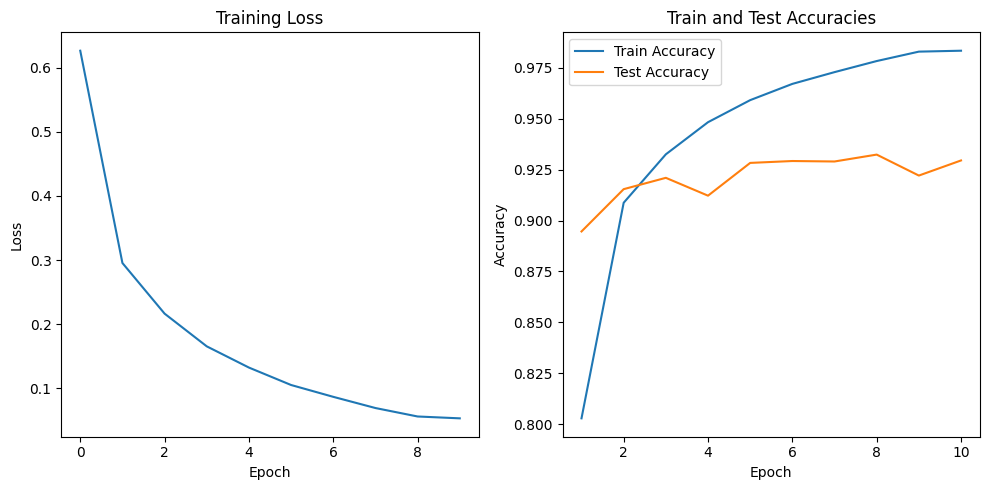

In [ ]:
class DigitModel(nn.Module):
    def __init__(self, num_features):
        super(DigitModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(64 * 4 * 4 + num_features, 128)
        self.activation = nn.LeakyReLU()
        self.output_layer = nn.Linear(128, 10)

    def forward(self, images, features):
        cnn_output = self.cnn(images)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)
        combined = torch.cat((cnn_output, features), dim=1)
        fc_output = self.fc(combined)
        fc_output = self.activation(fc_output)
        output = self.output_layer(fc_output)
        return output

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, features, _, digit_labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        digit_labels = digit_labels.to(device)

        optimizer.zero_grad()
        output = model(images, features)
        loss = criterion(output, digit_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

    accuracy = correct / total
    return running_loss / len(train_loader), accuracy


def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, features, _, digit_labels in test_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)

            output = model(images, features)
            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()
    accuracy = correct / total
    return accuracy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DigitModel(num_features=256).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']

num_epochs = 10
train_losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    test_accuracy = evaluate(model, test_loader, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Test Accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")

plt.subplot(1, 2, 2)
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracies")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Test with another activation function

Epoch 1/10 - Loss: 0.5936 - Train Accuracy: 0.8111 - Test Accuracy: 0.8900
Epoch 2/10 - Loss: 0.2859 - Train Accuracy: 0.9112 - Test Accuracy: 0.9085
Epoch 3/10 - Loss: 0.2136 - Train Accuracy: 0.9345 - Test Accuracy: 0.9138
Epoch 4/10 - Loss: 0.1667 - Train Accuracy: 0.9491 - Test Accuracy: 0.9177
Epoch 5/10 - Loss: 0.1292 - Train Accuracy: 0.9606 - Test Accuracy: 0.9154
Epoch 6/10 - Loss: 0.1006 - Train Accuracy: 0.9704 - Test Accuracy: 0.9173
Epoch 7/10 - Loss: 0.0775 - Train Accuracy: 0.9780 - Test Accuracy: 0.9143
Epoch 8/10 - Loss: 0.0590 - Train Accuracy: 0.9836 - Test Accuracy: 0.9140
Epoch 9/10 - Loss: 0.0482 - Train Accuracy: 0.9869 - Test Accuracy: 0.9135
Epoch 10/10 - Loss: 0.0461 - Train Accuracy: 0.9866 - Test Accuracy: 0.9106


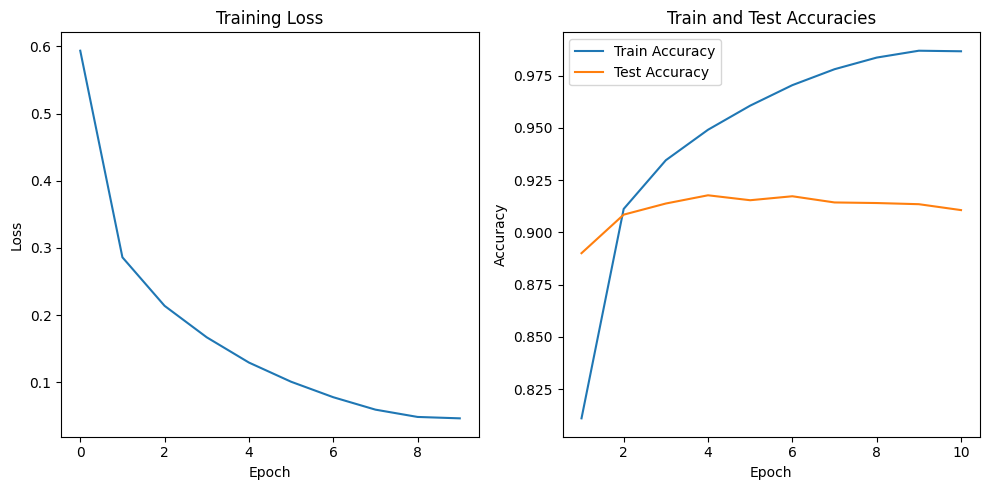

In [ ]:
class DigitModel(nn.Module):
    def __init__(self, num_features):
        super(DigitModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(64 * 4 * 4 + num_features, 128)
        self.activation = nn.Tanh()
        self.output_layer = nn.Linear(128, 10)

    def forward(self, images, features):
        cnn_output = self.cnn(images)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)
        combined = torch.cat((cnn_output, features), dim=1)
        fc_output = self.fc(combined)
        fc_output = self.activation(fc_output)
        output = self.output_layer(fc_output)
        return output

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, features, _, digit_labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        digit_labels = digit_labels.to(device)

        optimizer.zero_grad()
        output = model(images, features)
        loss = criterion(output, digit_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

    accuracy = correct / total
    return running_loss / len(train_loader), accuracy


def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, features, _, digit_labels in test_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)

            output = model(images, features)
            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()
    accuracy = correct / total
    return accuracy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DigitModel(num_features=256).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']

num_epochs = 10
train_losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    test_accuracy = evaluate(model, test_loader, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Test Accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")

plt.subplot(1, 2, 2)
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracies")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Epoch Tuning

Epoch 1/15 - Loss: 0.6450 - Train Accuracy: 0.7988 - Test Accuracy: 0.8747
Epoch 2/15 - Loss: 0.3033 - Train Accuracy: 0.9068 - Test Accuracy: 0.9086
Epoch 3/15 - Loss: 0.2227 - Train Accuracy: 0.9306 - Test Accuracy: 0.9216
Epoch 4/15 - Loss: 0.1696 - Train Accuracy: 0.9462 - Test Accuracy: 0.9243
Epoch 5/15 - Loss: 0.1373 - Train Accuracy: 0.9575 - Test Accuracy: 0.9244
Epoch 6/15 - Loss: 0.1070 - Train Accuracy: 0.9660 - Test Accuracy: 0.9223
Epoch 7/15 - Loss: 0.0910 - Train Accuracy: 0.9713 - Test Accuracy: 0.9277
Epoch 8/15 - Loss: 0.0728 - Train Accuracy: 0.9776 - Test Accuracy: 0.9298
Epoch 9/15 - Loss: 0.0649 - Train Accuracy: 0.9799 - Test Accuracy: 0.9252
Epoch 10/15 - Loss: 0.0549 - Train Accuracy: 0.9828 - Test Accuracy: 0.9281
Epoch 11/15 - Loss: 0.0493 - Train Accuracy: 0.9836 - Test Accuracy: 0.9219
Epoch 12/15 - Loss: 0.0466 - Train Accuracy: 0.9855 - Test Accuracy: 0.9270
Epoch 13/15 - Loss: 0.0387 - Train Accuracy: 0.9875 - Test Accuracy: 0.9222
Epoch 14/15 - Loss: 0

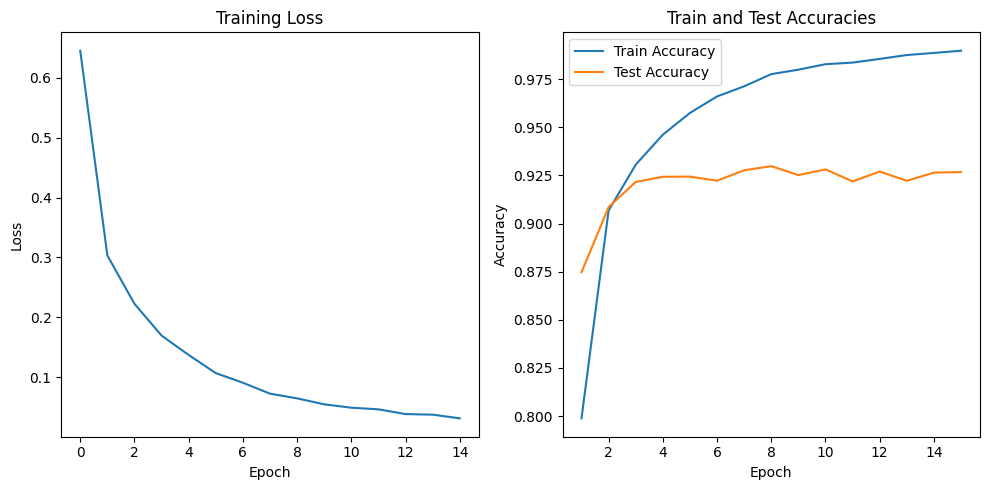

In [30]:
class DigitModel(nn.Module):
    def __init__(self, num_features):
        super(DigitModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(64 * 4 * 4 + num_features, 128)
        self.activation = nn.ReLU()
        self.output_layer = nn.Linear(128, 10)

    def forward(self, images, features):
        cnn_output = self.cnn(images)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)
        combined = torch.cat((cnn_output, features), dim=1)
        fc_output = self.fc(combined)
        fc_output = self.activation(fc_output)
        output = self.output_layer(fc_output)
        return output

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, features, _, digit_labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        digit_labels = digit_labels.to(device)

        optimizer.zero_grad()
        output = model(images, features)
        loss = criterion(output, digit_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

    accuracy = correct / total
    return running_loss / len(train_loader), accuracy


def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, features, _, digit_labels in test_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)

            output = model(images, features)
            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()
    accuracy = correct / total
    return accuracy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DigitModel(num_features=256).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']

num_epochs = 15
train_losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    test_accuracy = evaluate(model, test_loader, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Test Accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")

plt.subplot(1, 2, 2)
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracies")
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/20 - Loss: 0.6364 - Train Accuracy: 0.7985 - Test Accuracy: 0.8926
Epoch 2/20 - Loss: 0.2994 - Train Accuracy: 0.9055 - Test Accuracy: 0.9085
Epoch 3/20 - Loss: 0.2187 - Train Accuracy: 0.9311 - Test Accuracy: 0.9143
Epoch 4/20 - Loss: 0.1692 - Train Accuracy: 0.9470 - Test Accuracy: 0.9274
Epoch 5/20 - Loss: 0.1319 - Train Accuracy: 0.9587 - Test Accuracy: 0.9263
Epoch 6/20 - Loss: 0.1052 - Train Accuracy: 0.9672 - Test Accuracy: 0.9271
Epoch 7/20 - Loss: 0.0901 - Train Accuracy: 0.9711 - Test Accuracy: 0.9273
Epoch 8/20 - Loss: 0.0720 - Train Accuracy: 0.9763 - Test Accuracy: 0.9254
Epoch 9/20 - Loss: 0.0605 - Train Accuracy: 0.9806 - Test Accuracy: 0.9269
Epoch 10/20 - Loss: 0.0556 - Train Accuracy: 0.9822 - Test Accuracy: 0.9268
Epoch 11/20 - Loss: 0.0438 - Train Accuracy: 0.9858 - Test Accuracy: 0.9259
Epoch 12/20 - Loss: 0.0377 - Train Accuracy: 0.9879 - Test Accuracy: 0.9239
Epoch 13/20 - Loss: 0.0401 - Train Accuracy: 0.9871 - Test Accuracy: 0.9250
Epoch 14/20 - Loss: 0

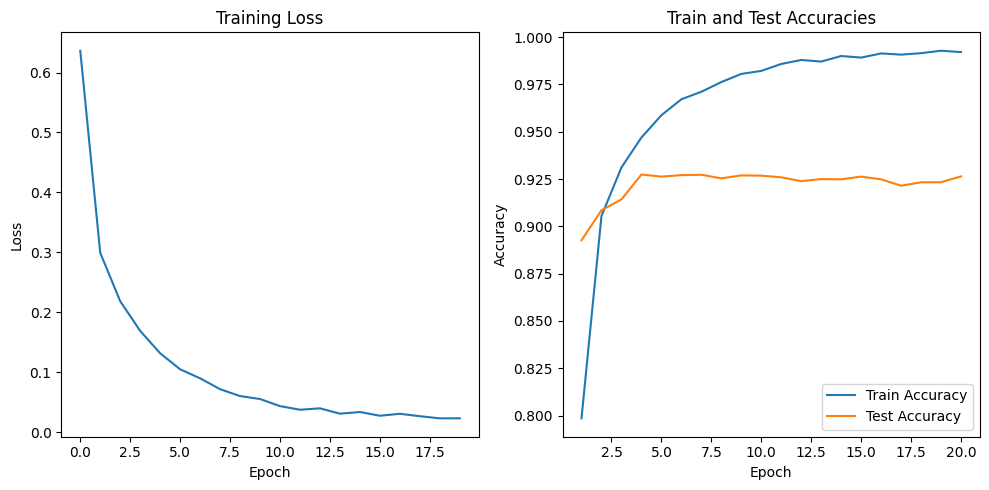

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class DigitModel(nn.Module):
    def __init__(self, num_features):
        super(DigitModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(64 * 4 * 4 + num_features, 128)
        self.activation = nn.ReLU()
        self.output_layer = nn.Linear(128, 10)

    def forward(self, images, features):
        cnn_output = self.cnn(images)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)
        combined = torch.cat((cnn_output, features), dim=1)
        fc_output = self.fc(combined)
        fc_output = self.activation(fc_output)
        output = self.output_layer(fc_output)
        return output

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, features, _, digit_labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        digit_labels = digit_labels.to(device)

        optimizer.zero_grad()
        output = model(images, features)
        loss = criterion(output, digit_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

    accuracy = correct / total
    return running_loss / len(train_loader), accuracy


def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, features, _, digit_labels in test_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)

            output = model(images, features)
            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()
    accuracy = correct / total
    return accuracy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DigitModel(num_features=256).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']

num_epochs = 20
train_losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    test_accuracy = evaluate(model, test_loader, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Test Accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")

plt.subplot(1, 2, 2)
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracies")
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/30 - Loss: 0.6462 - Train Accuracy: 0.7965 - Test Accuracy: 0.8877
Epoch 2/30 - Loss: 0.2973 - Train Accuracy: 0.9074 - Test Accuracy: 0.9144
Epoch 3/30 - Loss: 0.2171 - Train Accuracy: 0.9325 - Test Accuracy: 0.9194
Epoch 4/30 - Loss: 0.1658 - Train Accuracy: 0.9474 - Test Accuracy: 0.9225
Epoch 5/30 - Loss: 0.1329 - Train Accuracy: 0.9584 - Test Accuracy: 0.9228
Epoch 6/30 - Loss: 0.1078 - Train Accuracy: 0.9662 - Test Accuracy: 0.9250
Epoch 7/30 - Loss: 0.0873 - Train Accuracy: 0.9729 - Test Accuracy: 0.9263
Epoch 8/30 - Loss: 0.0767 - Train Accuracy: 0.9759 - Test Accuracy: 0.9261
Epoch 9/30 - Loss: 0.0617 - Train Accuracy: 0.9802 - Test Accuracy: 0.9241
Epoch 10/30 - Loss: 0.0535 - Train Accuracy: 0.9830 - Test Accuracy: 0.9330
Epoch 11/30 - Loss: 0.0482 - Train Accuracy: 0.9854 - Test Accuracy: 0.9258
Epoch 12/30 - Loss: 0.0388 - Train Accuracy: 0.9883 - Test Accuracy: 0.9231
Epoch 13/30 - Loss: 0.0394 - Train Accuracy: 0.9877 - Test Accuracy: 0.9279
Epoch 14/30 - Loss: 0

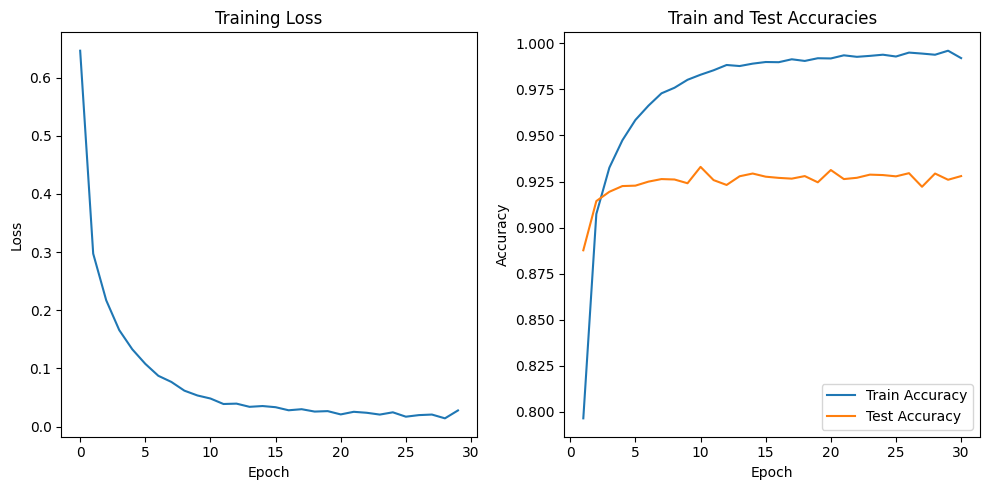

In [32]:
class DigitModel(nn.Module):
    def __init__(self, num_features):
        super(DigitModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(64 * 4 * 4 + num_features, 128)
        self.activation = nn.ReLU()
        self.output_layer = nn.Linear(128, 10)

    def forward(self, images, features):
        cnn_output = self.cnn(images)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)
        combined = torch.cat((cnn_output, features), dim=1)
        fc_output = self.fc(combined)
        fc_output = self.activation(fc_output)
        output = self.output_layer(fc_output)
        return output

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, features, _, digit_labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        digit_labels = digit_labels.to(device)

        optimizer.zero_grad()
        output = model(images, features)
        loss = criterion(output, digit_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

    accuracy = correct / total
    return running_loss / len(train_loader), accuracy


def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, features, _, digit_labels in test_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)

            output = model(images, features)
            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()
    accuracy = correct / total
    return accuracy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DigitModel(num_features=256).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']

num_epochs = 30
train_losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    test_accuracy = evaluate(model, test_loader, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Test Accuracy: {test_accuracy:.4f}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")

plt.subplot(1, 2, 2)
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracies")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Adding regularization techniques and values

Epoch 1/10 - Loss: 0.8154 - Train Accuracy: 0.7465 - Test Accuracy: 0.8812
Epoch 2/10 - Loss: 0.4527 - Train Accuracy: 0.8707 - Test Accuracy: 0.8982
Epoch 3/10 - Loss: 0.3743 - Train Accuracy: 0.8955 - Test Accuracy: 0.9139
Epoch 4/10 - Loss: 0.3316 - Train Accuracy: 0.9105 - Test Accuracy: 0.9192
Epoch 5/10 - Loss: 0.3030 - Train Accuracy: 0.9204 - Test Accuracy: 0.9263
Epoch 6/10 - Loss: 0.2836 - Train Accuracy: 0.9276 - Test Accuracy: 0.9300
Epoch 7/10 - Loss: 0.2674 - Train Accuracy: 0.9341 - Test Accuracy: 0.9311
Epoch 8/10 - Loss: 0.2512 - Train Accuracy: 0.9396 - Test Accuracy: 0.9350
Epoch 9/10 - Loss: 0.2390 - Train Accuracy: 0.9436 - Test Accuracy: 0.9343
Epoch 10/10 - Loss: 0.2306 - Train Accuracy: 0.9470 - Test Accuracy: 0.9335


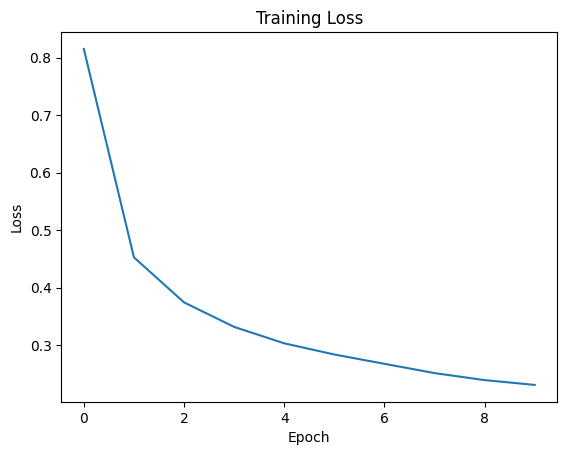

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


class DigitModel(nn.Module):
    def __init__(self, num_features, dropout_rate=0.5):
        super(DigitModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(64 * 4 * 4 + num_features, 128)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.output_layer = nn.Linear(128, 10)

    def forward(self, images, features):
        cnn_output = self.cnn(images)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)
        combined = torch.cat((cnn_output, features), dim=1)
        fc_output = self.fc(combined)
        fc_output = self.activation(fc_output)
        fc_output = self.dropout(fc_output)
        output = self.output_layer(fc_output)
        return output



def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, features, _, digit_labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        digit_labels = digit_labels.to(device)

        optimizer.zero_grad()
        output = model(images, features)
        loss = criterion(output, digit_labels)


        l2_lambda = 0.001
        l2_reg = torch.tensor(0.).to(device)
        for param in model.parameters():
            l2_reg += torch.norm(param)
        loss += l2_lambda * l2_reg

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

    accuracy = correct / total
    return running_loss / len(train_loader), accuracy



def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, features, _, digit_labels in test_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)

            output = model(images, features)
            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()
    accuracy = correct / total
    return accuracy



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DigitModel(num_features=256, dropout_rate=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']


num_epochs = 10
train_losses = []
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    test_accuracy = evaluate(model, test_loader, device)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Test Accuracy: {test_accuracy:.4f}")


plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [ ]:
# Change L2

Epoch 1/10 - Loss: 1.0336 - Train Accuracy: 0.7459 - Test Accuracy: 0.8851
Epoch 2/10 - Loss: 0.7260 - Train Accuracy: 0.8693 - Test Accuracy: 0.9072
Epoch 3/10 - Loss: 0.6767 - Train Accuracy: 0.8925 - Test Accuracy: 0.9144
Epoch 4/10 - Loss: 0.6531 - Train Accuracy: 0.9038 - Test Accuracy: 0.9235
Epoch 5/10 - Loss: 0.6416 - Train Accuracy: 0.9097 - Test Accuracy: 0.9181
Epoch 6/10 - Loss: 0.6323 - Train Accuracy: 0.9162 - Test Accuracy: 0.9256
Epoch 7/10 - Loss: 0.6232 - Train Accuracy: 0.9205 - Test Accuracy: 0.9311
Epoch 8/10 - Loss: 0.6145 - Train Accuracy: 0.9252 - Test Accuracy: 0.9295
Epoch 9/10 - Loss: 0.6129 - Train Accuracy: 0.9272 - Test Accuracy: 0.9311
Epoch 10/10 - Loss: 0.6061 - Train Accuracy: 0.9303 - Test Accuracy: 0.9288


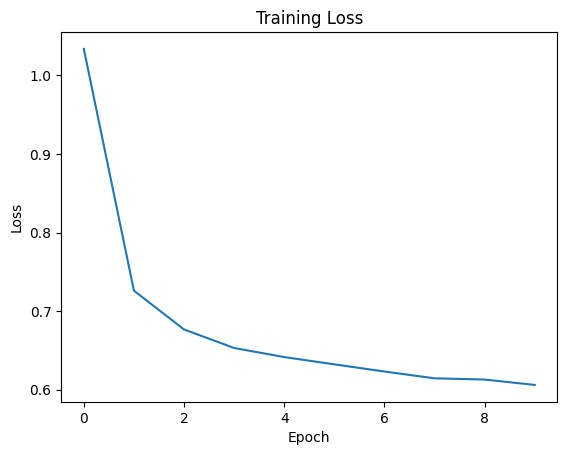

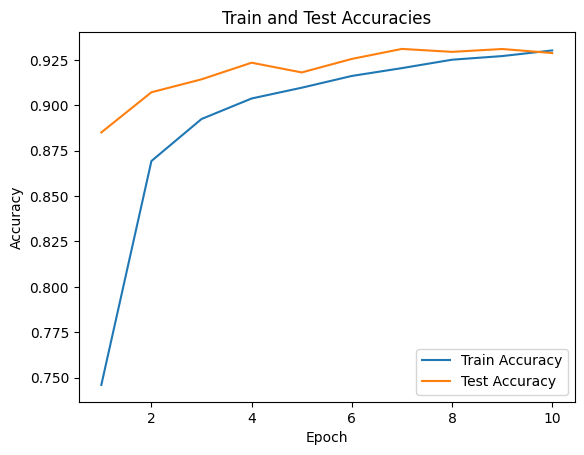

In [ ]:
class GigitModel(nn.Module):
  def __init__(self, num_features, dropout_rate=0.5):
        super(DigitModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(64 * 4 * 4 + num_features, 128)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.output_layer = nn.Linear(128, 10)

    def forward(self, images, features):
        cnn_output = self.cnn(images)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)
        combined = torch.cat((cnn_output, features), dim=1)
        fc_output = self.fc(combined)
        fc_output = self.activation(fc_output)
        fc_output = self.dropout(fc_output)
        output = self.output_layer(fc_output)
        return output


def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, features, _, digit_labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        digit_labels = digit_labels.to(device)

        optimizer.zero_grad()
        output = model(images, features)
        loss = criterion(output, digit_labels)


        l2_lambda = 0.01
        l2_reg = torch.tensor(0.).to(device)
        for param in model.parameters():
            l2_reg += torch.norm(param)
        loss += l2_lambda * l2_reg

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

    accuracy = correct / total
    return running_loss / len(train_loader), accuracy



def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, features, _, digit_labels in test_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)

            output = model(images, features)
            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()
    accuracy = correct / total
    return accuracy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DigitModel(num_features=256, dropout_rate=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']

num_epochs = 10
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    test_accuracy = evaluate(model, test_loader, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Test Accuracy: {test_accuracy:.4f}")

plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracies")
plt.legend()
plt.show()

In [ ]:
#Ensemble Model

Epoch 1/10 - Train Losses: [0.8855114701205987, 0.9044023738550478, 0.880158931334644] - Train Accuracy: 0.7129 - Test Accuracy: 0.8834
Epoch 2/10 - Train Losses: [0.475917729122171, 0.49772904508276533, 0.4700840810564027] - Train Accuracy: 0.8533 - Test Accuracy: 0.9125
Epoch 3/10 - Train Losses: [0.38300230055411993, 0.40185251028171737, 0.3811771569888729] - Train Accuracy: 0.8811 - Test Accuracy: 0.9215
Epoch 4/10 - Train Losses: [0.33400249739350285, 0.33739223143757024, 0.3226470059748969] - Train Accuracy: 0.8981 - Test Accuracy: 0.9302
Epoch 5/10 - Train Losses: [0.29753377127336034, 0.30532764990541983, 0.2922714465160741] - Train Accuracy: 0.9074 - Test Accuracy: 0.9344
Epoch 6/10 - Train Losses: [0.27205951446329735, 0.27566775068767796, 0.2611413777811822] - Train Accuracy: 0.9176 - Test Accuracy: 0.9367
Epoch 7/10 - Train Losses: [0.24720161983262756, 0.2534883716570607, 0.24309073743630827] - Train Accuracy: 0.9225 - Test Accuracy: 0.9415
Epoch 8/10 - Train Losses: [0.22

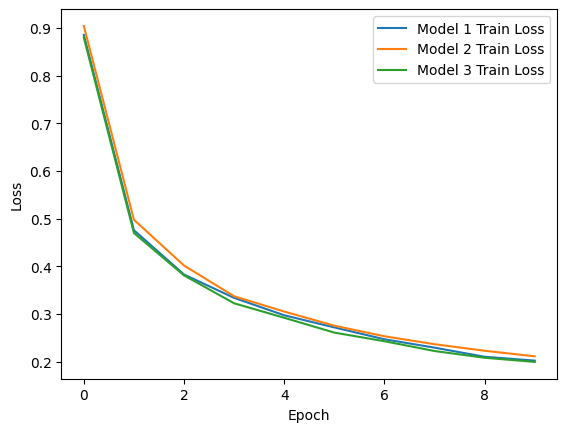

Epoch 1 Test Accuracy: 0.8834
Epoch 2 Test Accuracy: 0.9125
Epoch 3 Test Accuracy: 0.9215
Epoch 4 Test Accuracy: 0.9302
Epoch 5 Test Accuracy: 0.9344
Epoch 6 Test Accuracy: 0.9367
Epoch 7 Test Accuracy: 0.9415
Epoch 8 Test Accuracy: 0.9415
Epoch 9 Test Accuracy: 0.9437
Epoch 10 Test Accuracy: 0.9438


In [ ]:
class DigitModel(nn.Module):
    def __init__(self, num_features, dropout_rate=0.5):
        super(DigitModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(64 * 4 * 4, 128)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.output_layer = nn.Linear(128 + num_features, 10)

    def forward(self, images, features):
        cnn_output = self.cnn(images)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)
        fc_output = self.fc(cnn_output)
        fc_output = self.activation(fc_output)
        fc_output = self.dropout(fc_output)
        combined = torch.cat((fc_output, features), dim=1)
        output = self.output_layer(combined)
        return output

def train_ensemble(models, train_loader, criterion, optimizers, device):
    for model, optimizer in zip(models, optimizers):
        model.train()

    running_losses = [0.0] * len(models)
    correct = 0
    total = 0

    for batch_idx, (images, features, _, digit_labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        digit_labels = digit_labels.to(device)

        for optimizer in optimizers:
            optimizer.zero_grad()

        for idx, model in enumerate(models):
            output = model(images, features)
            loss = criterion(output, digit_labels)
            loss.backward()
            optimizers[idx].step()
            running_losses[idx] += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

    accuracy = correct / total
    return [running_loss / len(train_loader) for running_loss in running_losses], accuracy

def evaluate_ensemble(models, test_loader, device):
    for model in models:
        model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images, features, _, digit_labels in test_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)

            outputs = []
            for model in models:
                output = model(images, features)
                outputs.append(output)
            combined_output = torch.stack(outputs, dim=0).mean(dim=0)

            _, predicted = torch.max(combined_output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()

    accuracy = correct / total
    return accuracy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_models = 3

models = []
optimizers = []
for _ in range(num_models):
    model = DigitModel(num_features=256, dropout_rate=0.5).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    models.append(model)
    optimizers.append(optimizer)

criterion = nn.CrossEntropyLoss()

train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']

num_epochs = 10
train_losses = [[] for _ in range(num_models)]
test_accuracy = []

for epoch in range(num_epochs):
    epoch_train_losses, train_accuracy = train_ensemble(models, train_loader, criterion, optimizers, device)
    test_acc = evaluate_ensemble(models, test_loader, device)
    for i, epoch_train_loss in enumerate(epoch_train_losses):
        train_losses[i].append(epoch_train_loss)
    test_accuracy.append(test_acc)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Losses: {epoch_train_losses} - Train Accuracy: {train_accuracy:.4f} - Test Accuracy: {test_acc:.4f}")

for i, train_loss in enumerate(train_losses):
    plt.plot(train_loss, label=f"Model {i+1} Train Loss")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

for i, acc in enumerate(test_accuracy):
    print(f"Epoch {i+1} Test Accuracy: {acc:.4f}")


In [ ]:
#Ensemble + L2 Regularization + DropOut Layer

Epoch 1/10 - Train Losses: [0.9242772840932488, 0.9275397668197465, 0.9212515144459983] - Train Accuracy: 0.7103 - Test Accuracy: 0.8817
Epoch 2/10 - Train Losses: [0.5478283723375437, 0.5037331411928765, 0.5154495139493108] - Train Accuracy: 0.8522 - Test Accuracy: 0.9069
Epoch 3/10 - Train Losses: [0.4497586958634574, 0.41302865702333225, 0.42694841560397323] - Train Accuracy: 0.8802 - Test Accuracy: 0.9210
Epoch 4/10 - Train Losses: [0.3948573470909967, 0.3628809648567934, 0.36991722174862557] - Train Accuracy: 0.8998 - Test Accuracy: 0.9284
Epoch 5/10 - Train Losses: [0.35497530360720053, 0.329176545389362, 0.3377439113679344] - Train Accuracy: 0.9090 - Test Accuracy: 0.9312
Epoch 6/10 - Train Losses: [0.3312247574154629, 0.3056894999974445, 0.312142618262628] - Train Accuracy: 0.9180 - Test Accuracy: 0.9399
Epoch 7/10 - Train Losses: [0.3129942869104302, 0.2846885847845184, 0.29276049183185165] - Train Accuracy: 0.9248 - Test Accuracy: 0.9429
Epoch 8/10 - Train Losses: [0.29702207

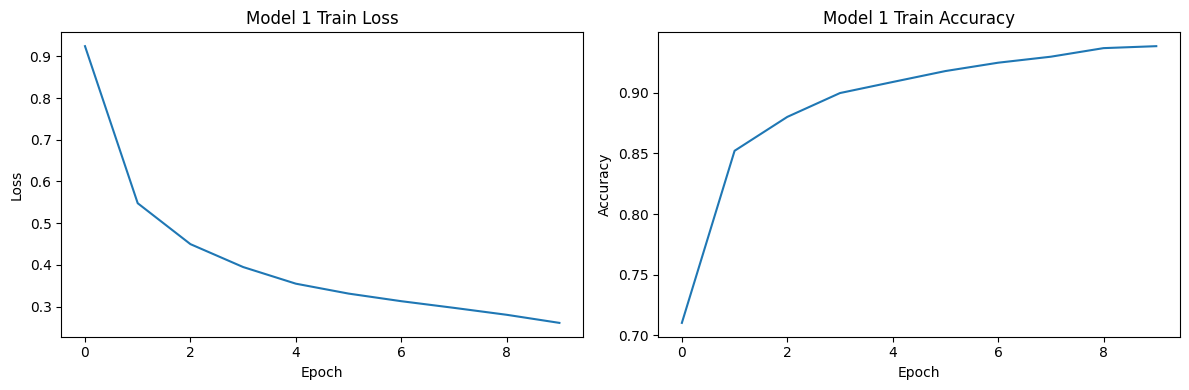

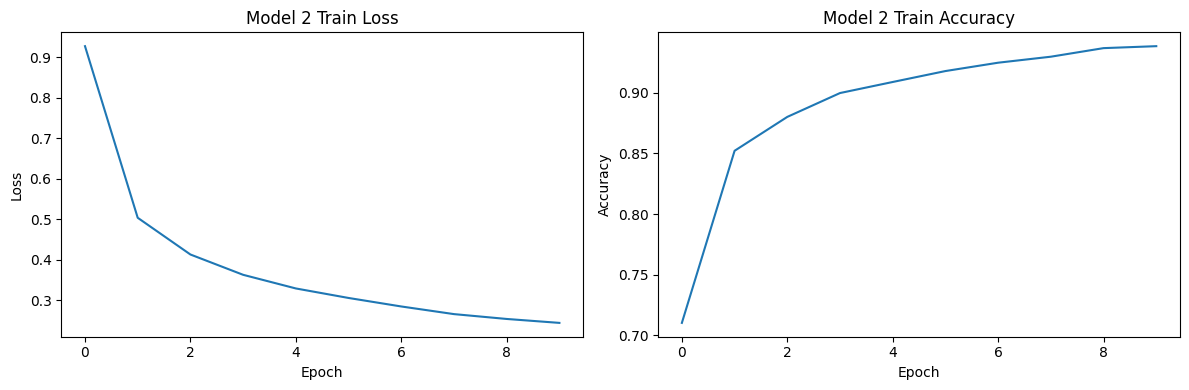

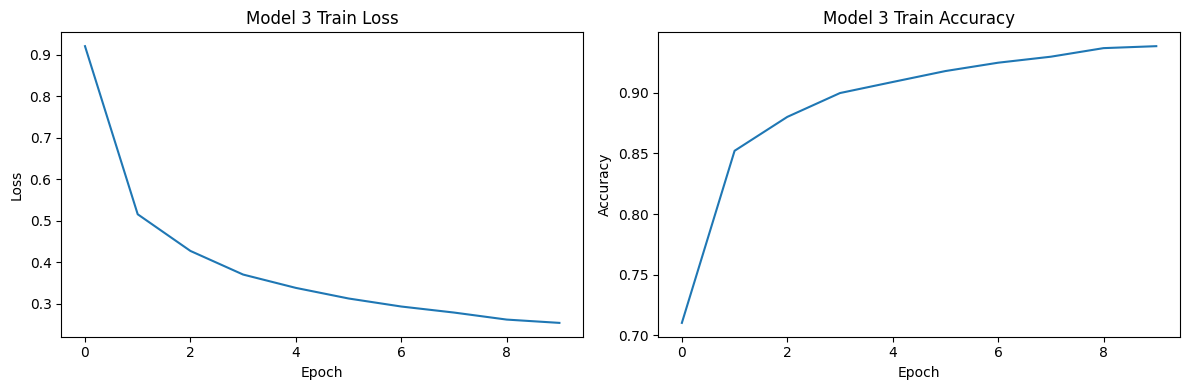

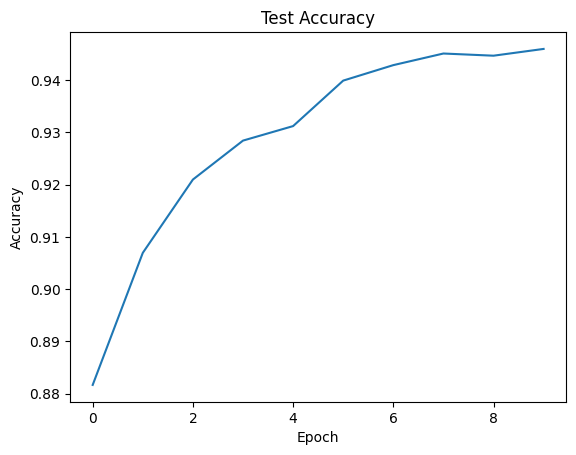

Epoch 1 Test Accuracy: 0.8817
Epoch 2 Test Accuracy: 0.9069
Epoch 3 Test Accuracy: 0.9210
Epoch 4 Test Accuracy: 0.9284
Epoch 5 Test Accuracy: 0.9312
Epoch 6 Test Accuracy: 0.9399
Epoch 7 Test Accuracy: 0.9429
Epoch 8 Test Accuracy: 0.9451
Epoch 9 Test Accuracy: 0.9447
Epoch 10 Test Accuracy: 0.9460


In [ ]:
class DigitModel(nn.Module):
    def __init__(self, num_features, dropout_rate=0.5, l2_lambda=0.001):
        super(DigitModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(64 * 4 * 4, 128)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.output_layer = nn.Linear(128 + num_features, 10)

        self.l2_lambda = l2_lambda

    def forward(self, images, features):
        cnn_output = self.cnn(images)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)  # Flatten the CNN output
        fc_output = self.fc(cnn_output)
        fc_output = self.activation(fc_output)
        fc_output = self.dropout(fc_output)
        combined = torch.cat((fc_output, features), dim=1)
        output = self.output_layer(combined)
        return output

    def l2_regularization(self):
        l2_reg = torch.tensor(0.)
        for param in self.parameters():
            l2_reg += torch.norm(param)
        return self.l2_lambda * l2_reg


def train_ensemble(models, train_loader, criterion, optimizers, device):
    for model, optimizer in zip(models, optimizers):
        model.train()

    running_losses = [0.0] * len(models)
    correct = 0
    total = 0

    for batch_idx, (images, features, _, digit_labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        digit_labels = digit_labels.to(device)

        for optimizer in optimizers:
            optimizer.zero_grad()

        for idx, model in enumerate(models):
            output = model(images, features)
            loss = criterion(output, digit_labels)
            loss += model.l2_regularization()  # Apply L2 regularization
            loss.backward()
            optimizers[idx].step()
            running_losses[idx] += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

    accuracy = correct / total
    return [running_loss / len(train_loader) for running_loss in running_losses], accuracy


def evaluate_ensemble(models, test_loader, device):
    for model in models:
        model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images, features, _, digit_labels in test_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)

            outputs = []
            for model in models:
                output = model(images, features)
                outputs.append(output)
            combined_output = torch.stack(outputs, dim=0).mean(dim=0)

            _, predicted = torch.max(combined_output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()

    accuracy = correct / total
    return accuracy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_models = 3

models = []
optimizers = []
for _ in range(num_models):
    model = DigitModel(num_features=256, dropout_rate=0.5).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    models.append(model)
    optimizers.append(optimizer)

criterion = nn.CrossEntropyLoss()

train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']

num_epochs = 10
train_losses = [[] for _ in range(num_models)]
train_accuracies = [[] for _ in range(num_models)]
test_accuracies = []

for epoch in range(num_epochs):
    epoch_train_losses, train_accuracy = train_ensemble(models, train_loader, criterion, optimizers, device)
    test_accuracy = evaluate_ensemble(models, test_loader, device)
    for i, epoch_train_loss in enumerate(epoch_train_losses):
        train_losses[i].append(epoch_train_loss)
        train_accuracies[i].append(train_accuracy)
    test_accuracies.append(test_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Losses: {epoch_train_losses} - Train Accuracy: {train_accuracy:.4f} - Test Accuracy: {test_accuracy:.4f}")

for i, (train_loss, train_acc) in enumerate(zip(train_losses, train_accuracies)):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"Model {i+1} Train Loss")

    plt.subplot(1, 2, 2)
    plt.plot(train_acc)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f"Model {i+1} Train Accuracy")
    plt.tight_layout()
    plt.show()

plt.plot(test_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.show()

for i, acc in enumerate(test_accuracies):
    print(f"Epoch {i+1} Test Accuracy: {acc:.4f}")

In [ ]:
#part2

In [ ]:
#Triplet Loss

In [ ]:
class triplet_loss(nn.Module):
    def __init__(self, margin: float = 0.005, device=torch.device('cpu')):
        super().__init__()
        self.margin = torch.tensor(margin)
        self.device = device

    def forward(self, embeddings, labels):
        dp, dn = self.batch_hard_triplet_loss(embeddings, labels)

        triplet_loss = torch.mean(torch.clamp(dp - dn + self.margin, min=0))
        return triplet_loss

    # def forward(self, embeddings, labels):
        # dp, dn = self.batch_hard_triplet_loss(embeddings, labels)
        # triplet_loss = torch.sum(torch.clamp(dp - dn + self.margin, min=0))
        # return triplet_loss / embeddings.size(0)

    def batch_hard_triplet_loss(self, embeddings, labels):
        dists = self.euclidean_dist(embeddings, embeddings)

        same_identity_mask = torch.eq(labels[:, None], labels[None, :])
        negative_mask = torch.logical_not(same_identity_mask)
        positive_mask = torch.logical_xor(same_identity_mask, torch.eye(labels.shape[0], dtype=torch.bool).to(self.device))

        dp, _ = torch.max(dists * positive_mask.int(), dim=1)

        dn = torch.zeros_like(dp)
        for i in range(dists.shape[0]):
            dn[i] = torch.min(dists[i, :][negative_mask[i, :]])

        return dp, dn

    def all_diffs(self, a, b):
        return a[:, None] - b[None, :]

    def euclidean_dist(self, embed1, embed2):
        diffs = self.all_diffs(embed1, embed2)
        t1 = torch.square(diffs)
        t2 = torch.sum(t1, dim=-1)
        return torch.sqrt(t2 + 1e-12)

Epoch 1/10
Train Loss: 0.8836 - Test Loss: 1.9930
Train Accuracy: 0.7980 - Test Accuracy: 0.8935
Train Triplet Loss: 2.0639 - Test Triplet Loss: 1.6401
Train Cross Entropy Loss: 0.6772 - Test Cross Entropy Loss: 0.3529
Train Total Loss: 0.8836 - Test Total Loss: 1.9930

Epoch 2/10
Train Loss: 0.3898 - Test Loss: 1.3849
Train Accuracy: 0.9145 - Test Accuracy: 0.9051
Train Triplet Loss: 1.0375 - Test Triplet Loss: 1.0795
Train Cross Entropy Loss: 0.2860 - Test Cross Entropy Loss: 0.3054
Train Total Loss: 0.3898 - Test Total Loss: 1.3849

Epoch 3/10
Train Loss: 0.2689 - Test Loss: 1.1792
Train Accuracy: 0.9363 - Test Accuracy: 0.9178
Train Triplet Loss: 0.6036 - Test Triplet Loss: 0.9134
Train Cross Entropy Loss: 0.2085 - Test Cross Entropy Loss: 0.2659
Train Total Loss: 0.2689 - Test Total Loss: 1.1792

Epoch 4/10
Train Loss: 0.2062 - Test Loss: 1.0546
Train Accuracy: 0.9522 - Test Accuracy: 0.9210
Train Triplet Loss: 0.4564 - Test Triplet Loss: 0.8017
Train Cross Entropy Loss: 0.1606 - 

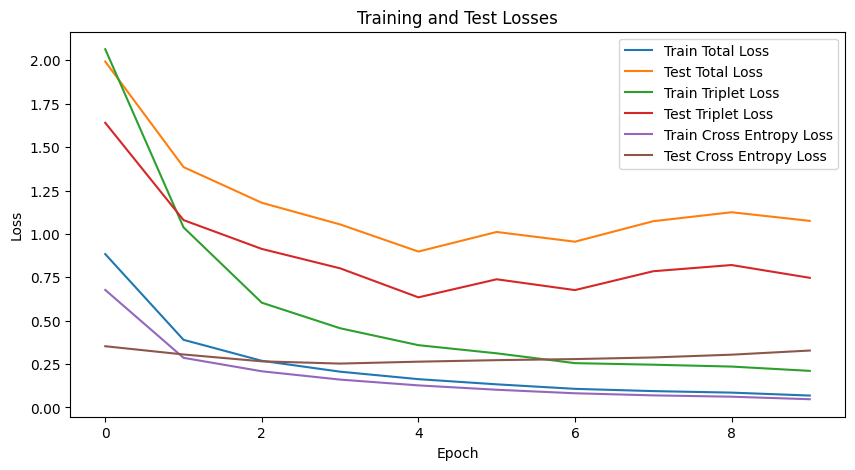

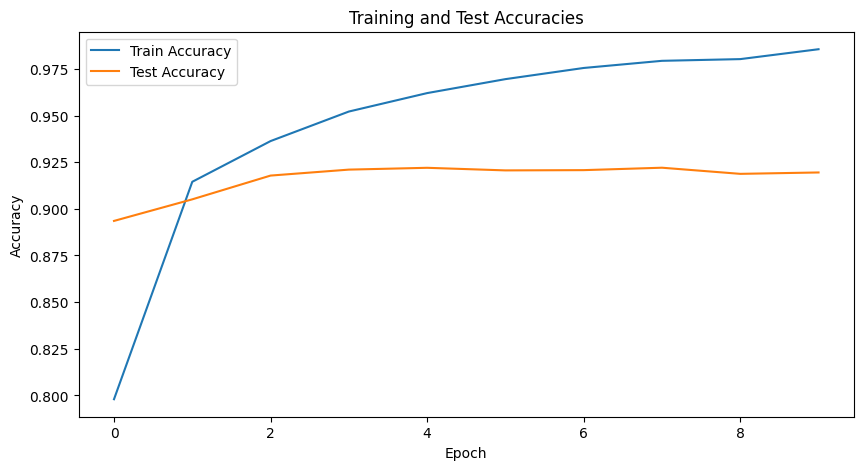

In [ ]:
class DigitModel(nn.Module):
    def __init__(self, num_features):
        super(DigitModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(64 * 4 * 4 + num_features, 128)
        self.output_layer = nn.Linear(128, 10)

    def forward(self, images, features):
        cnn_output = self.cnn(images)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)
        combined = torch.cat((cnn_output, features), dim=1
        f = F.relu(self.fc(combined))
        output = self.output_layer(f)
        return f, output

class TripletLoss(nn.Module):
    def __init__(self, margin: float = 0.005, device=torch.device('cpu')):
        super().__init__()
        self.margin = torch.tensor(margin)
        self.device = device

    def forward(self, embeddings, labels):
        dp, dn = self.batch_hard_triplet_loss(embeddings, labels)
        triplet_loss = torch.mean(torch.clamp(dp - dn + self.margin, min=0))
        return triplet_loss

    def batch_hard_triplet_loss(self, embeddings, labels):
        dists = self.euclidean_dist(embeddings, embeddings)

        same_identity_mask = torch.eq(labels[:, None], labels[None, :])
        negative_mask = torch.logical_not(same_identity_mask)
        positive_mask = torch.logical_xor(same_identity_mask, torch.eye(labels.shape[0], dtype=torch.bool).to(self.device))

        dp, _ = torch.max(dists * positive_mask.int(), dim=1)

        dn = torch.zeros_like(dp)
        for i in range(dists.shape[0]):
            dn[i] = torch.min(dists[i, :][negative_mask[i, :]])

        return dp, dn

    def all_diffs(self, a, b):
        return a[:, None] - b[None, :]

    def euclidean_dist(self, embed1, embed2):
        diffs = self.all_diffs(embed1, embed2)
        t1 = torch.square(diffs)
        t2 = torch.sum(t1, dim=-1)
        return torch.sqrt(t2 + 1e-12)


def train(model, train_loader, criterion, triplet_loss, optimizer, landa):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    for batch_idx, (images, features, domain_labels, digit_labels) in enumerate(train_loader):
        optimizer.zero_grad()
        f, output = model(images, features)
        loss_ce = criterion(output, digit_labels)
        loss_triplet = triplet_loss(f, domain_labels)
        loss = loss_ce + landa * loss_triplet
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

        triplet_loss_sum += loss_triplet.item()
        cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(train_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(train_loader)
    total_loss = running_loss / len(train_loader)
    return total_loss, accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss


def evaluate(model, test_loader, criterion, triplet_loss):
    model.eval()
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    with torch.no_grad():
        for images, features, domain_labels, digit_labels in test_loader:
            f, output = model(images, features)
            loss_ce = criterion(output, digit_labels)
            loss_triplet = triplet_loss(f, domain_labels)

            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()

            triplet_loss_sum += loss_triplet.item()
            cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(test_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(test_loader)
    total_loss = (avg_triplet_loss + avg_cross_entropy_loss)
    return accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss, total_loss


model = DigitModel(num_features=256)
criterion = nn.CrossEntropyLoss()
triplet_loss = TripletLoss(margin=0.005)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

num_epochs = 10
landa = 0.1

train_losses = []
test_losses = []
train_triplet_losses = []
test_triplet_losses = []
train_cross_entropy_losses = []
test_cross_entropy_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_accuracy, train_triplet_loss, train_cross_entropy_loss = train(model, train_loader, criterion, triplet_loss, optimizer, landa)
    test_accuracy, test_triplet_loss, test_cross_entropy_loss, test_total_loss = evaluate(model, test_loader, criterion, triplet_loss)

    train_losses.append(train_loss)
    test_losses.append(test_total_loss)
    train_triplet_losses.append(train_triplet_loss)
    test_triplet_losses.append(test_triplet_loss)
    train_cross_entropy_losses.append(train_cross_entropy_loss)
    test_cross_entropy_losses.append(test_cross_entropy_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} - Test Loss: {test_total_loss:.4f}")
    print(f"Train Accuracy: {train_accuracy:.4f} - Test Accuracy: {test_accuracy:.4f}")
    print(f"Train Triplet Loss: {train_triplet_loss:.4f} - Test Triplet Loss: {test_triplet_loss:.4f}")
    print(f"Train Cross Entropy Loss: {train_cross_entropy_loss:.4f} - Test Cross Entropy Loss: {test_cross_entropy_loss:.4f}")
    print(f"Train Total Loss: {train_loss:.4f} - Test Total Loss: {test_total_loss:.4f}")
    print()

plt.plot(train_losses, label='Train Total Loss')
plt.plot(test_losses, label='Test Total Loss')
plt.plot(train_triplet_losses, label='Train Triplet Loss')
plt.plot(test_triplet_losses, label='Test Triplet Loss')
plt.plot(train_cross_entropy_losses, label='Train Cross Entropy Loss')
plt.plot(test_cross_entropy_losses, label='Test Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Losses')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Test Accuracies')
plt.show()


In [ ]:
# Margin_values Tuning Based On Triplet loss Reduce

Epoch 1/10
Train Loss: 0.8718 - Test Loss: 1.9357
Train Accuracy: 0.7973 - Test Accuracy: 0.8898
Train Triplet Loss: 1.9682 - Test Triplet Loss: 1.5550
Train Cross Entropy Loss: 0.6750 - Test Cross Entropy Loss: 0.3807
Train Total Loss: 0.8718 - Test Total Loss: 1.9357

Epoch 2/10
Train Loss: 0.3693 - Test Loss: 1.4126
Train Accuracy: 0.9176 - Test Accuracy: 0.9029
Train Triplet Loss: 0.9714 - Test Triplet Loss: 1.0950
Train Cross Entropy Loss: 0.2721 - Test Cross Entropy Loss: 0.3176
Train Total Loss: 0.3693 - Test Total Loss: 1.4126

Epoch 3/10
Train Loss: 0.2560 - Test Loss: 1.2173
Train Accuracy: 0.9410 - Test Accuracy: 0.9213
Train Triplet Loss: 0.6198 - Test Triplet Loss: 0.9603
Train Cross Entropy Loss: 0.1940 - Test Cross Entropy Loss: 0.2570
Train Total Loss: 0.2560 - Test Total Loss: 1.2173

Epoch 4/10
Train Loss: 0.1937 - Test Loss: 1.0971
Train Accuracy: 0.9556 - Test Accuracy: 0.9215
Train Triplet Loss: 0.4489 - Test Triplet Loss: 0.8375
Train Cross Entropy Loss: 0.1488 - 

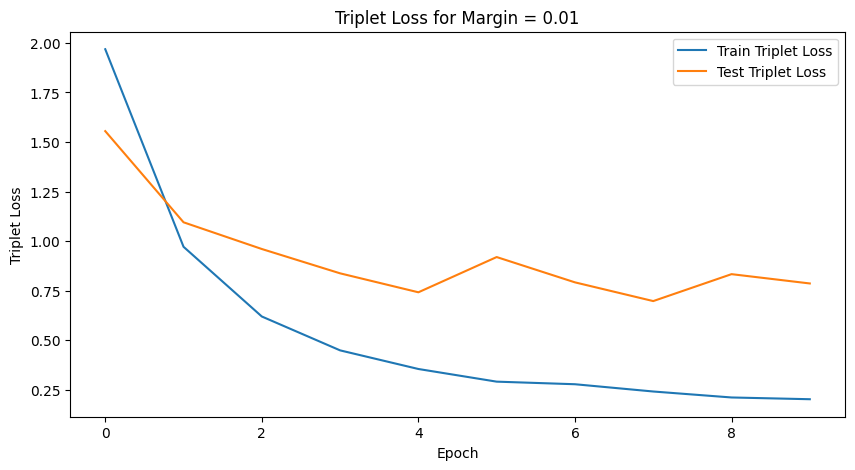

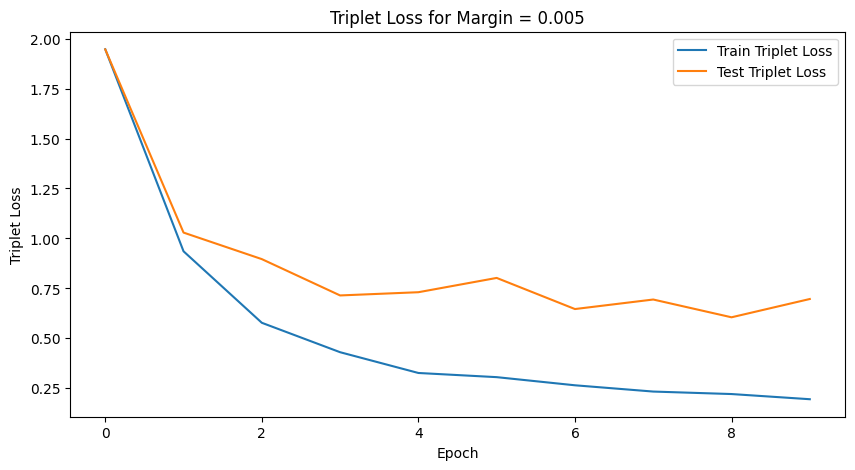

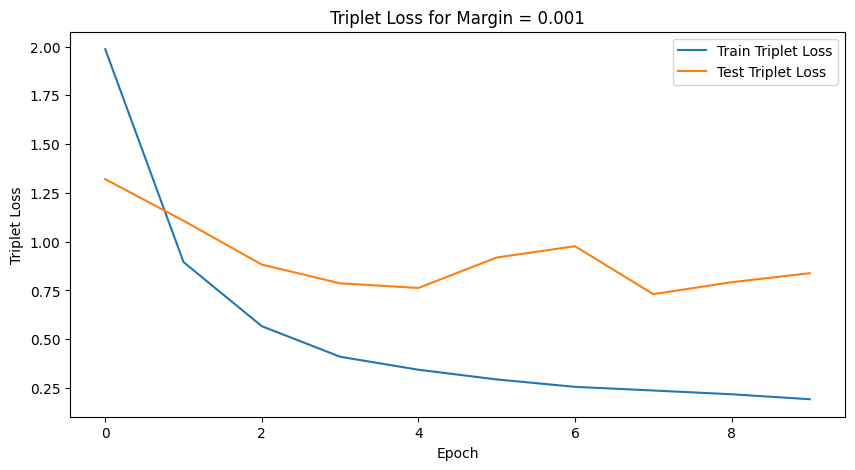

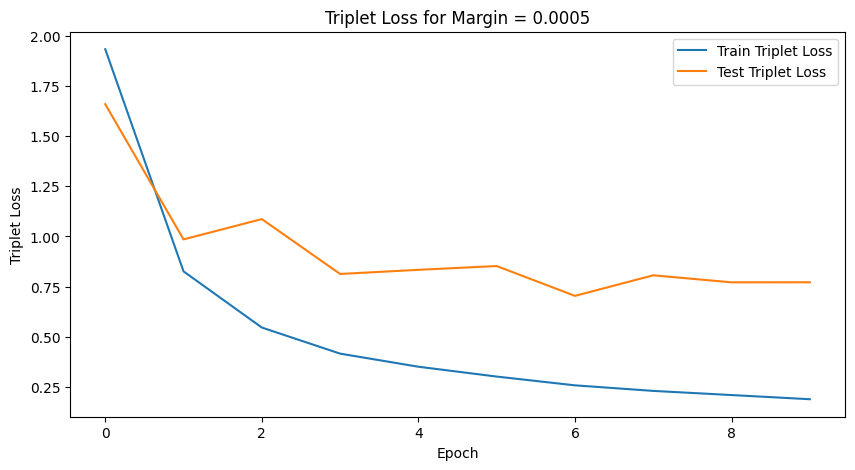

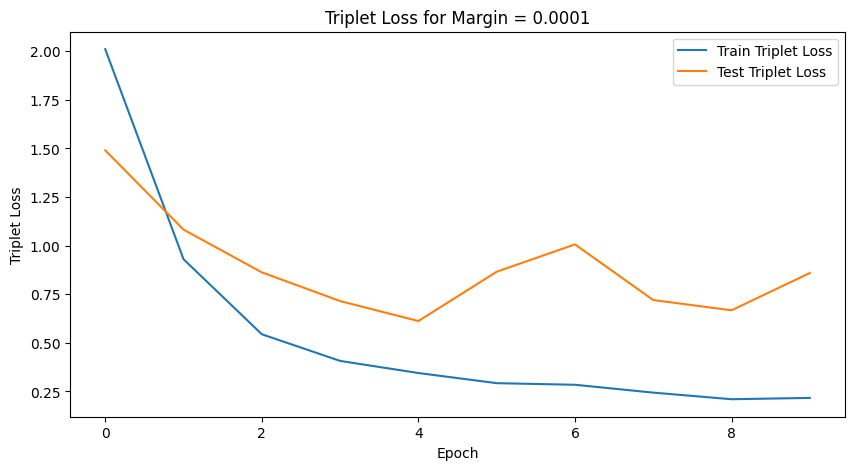

The best margin value is 0.005 with an average test triplet loss of 0.8764.


In [ ]:
class DigitModel(nn.Module):
    def __init__(self, num_features):
        super(DigitModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(64 * 4 * 4 + num_features, 128)
        self.output_layer = nn.Linear(128, 10)

    def forward(self, images, features):
        cnn_output = self.cnn(images)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)
        combined = torch.cat((cnn_output, features), dim=1)
        f = F.relu(self.fc(combined))
        output = self.output_layer(f)
        return f, output

class TripletLoss(nn.Module):
    def __init__(self, margin: float = 0.005, device=torch.device('cpu')):
        super().__init__()
        self.margin = torch.tensor(margin)
        self.device = device

    def forward(self, embeddings, labels):
        dp, dn = self.batch_hard_triplet_loss(embeddings, labels)
        triplet_loss = torch.mean(torch.clamp(dp - dn + self.margin, min=0))
        return triplet_loss

    def batch_hard_triplet_loss(self, embeddings, labels):
        dists = self.euclidean_dist(embeddings, embeddings)

        same_identity_mask = torch.eq(labels[:, None], labels[None, :])
        negative_mask = torch.logical_not(same_identity_mask)
        positive_mask = torch.logical_xor(same_identity_mask, torch.eye(labels.shape[0], dtype=torch.bool).to(self.device))

        dp, _ = torch.max(dists * positive_mask.int(), dim=1)

        dn = torch.zeros_like(dp)
        for i in range(dists.shape[0]):
            dn[i] = torch.min(dists[i, :][negative_mask[i, :]])

        return dp, dn

    def all_diffs(self, a, b):
        return a[:, None] - b[None, :]

    def euclidean_dist(self, embed1, embed2):
        diffs = self.all_diffs(embed1, embed2)
        t1 = torch.square(diffs)
        t2 = torch.sum(t1, dim=-1)
        return torch.sqrt(t2 + 1e-12)


def train(model, train_loader, criterion, triplet_loss, optimizer, landa):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    for batch_idx, (images, features, domain_labels, digit_labels) in enumerate(train_loader):
        optimizer.zero_grad()
        f, output = model(images, features)
        loss_ce = criterion(output, digit_labels)
        loss_triplet = triplet_loss(f, domain_labels)
        loss = loss_ce + landa * loss_triplet
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

        triplet_loss_sum += loss_triplet.item()
        cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(train_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(train_loader)
    total_loss = running_loss / len(train_loader)
    return total_loss, accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss


def evaluate(model, test_loader, criterion, triplet_loss):
    model.eval()
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    with torch.no_grad():
        for images, features, domain_labels, digit_labels in test_loader:
            f, output = model(images, features)
            loss_ce = criterion(output, digit_labels)
            loss_triplet = triplet_loss(f, domain_labels)

            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()

            triplet_loss_sum += loss_triplet.item()
            cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(test_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(test_loader)
    total_loss = (avg_triplet_loss + avg_cross_entropy_loss)
    return accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss, total_loss

train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']

num_epochs = 10
landa = 0.1

margin_values = [0.01, 0.005, 0.001, 0.0005, 0.0001]
results = []

for margin in margin_values:
    model = DigitModel(num_features=256)
    criterion = nn.CrossEntropyLoss()
    triplet_loss = TripletLoss(margin=margin)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    test_losses = []
    train_triplet_losses = []
    test_triplet_losses = []
    train_cross_entropy_losses = []
    test_cross_entropy_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy, train_triplet_loss, train_cross_entropy_loss = train(model, train_loader, criterion, triplet_loss, optimizer, landa)
        test_accuracy, test_triplet_loss, test_cross_entropy_loss, test_total_loss = evaluate(model, test_loader, criterion, triplet_loss)

        train_losses.append(train_loss)
        test_losses.append(test_total_loss)
        train_triplet_losses.append(train_triplet_loss)
        test_triplet_losses.append(test_triplet_loss)
        train_cross_entropy_losses.append(train_cross_entropy_loss)
        test_cross_entropy_losses.append(test_cross_entropy_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f} - Test Loss: {test_total_loss:.4f}")
        print(f"Train Accuracy: {train_accuracy:.4f} - Test Accuracy: {test_accuracy:.4f}")
        print(f"Train Triplet Loss: {train_triplet_loss:.4f} - Test Triplet Loss: {test_triplet_loss:.4f}")
        print(f"Train Cross Entropy Loss: {train_cross_entropy_loss:.4f} - Test Cross Entropy Loss: {test_cross_entropy_loss:.4f}")
        print(f"Train Total Loss: {train_loss:.4f} - Test Total Loss: {test_total_loss:.4f}")
        print()

    results.append({
        'margin': margin,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_triplet_losses': train_triplet_losses,
        'test_triplet_losses': test_triplet_losses,
        'train_cross_entropy_losses': train_cross_entropy_losses,
        'test_cross_entropy_losses': test_cross_entropy_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    })

for result in results:
    margin = result['margin']
    train_triplet_losses = result['train_triplet_losses']
    test_triplet_losses = result['test_triplet_losses']

    plt.figure(figsize=(10, 5))
    plt.plot(train_triplet_losses, label='Train Triplet Loss')
    plt.plot(test_triplet_losses, label='Test Triplet Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Triplet Loss')
    plt.legend()
    plt.title(f'Triplet Loss for Margin = {margin}')
    plt.show()

best_margin = None
best_avg_triplet_loss = float('inf')

for result in results:
    margin = result['margin']
    test_triplet_losses = result['test_triplet_losses']
    avg_triplet_loss = sum(test_triplet_losses) / len(test_triplet_losses)

    if avg_triplet_loss < best_avg_triplet_loss:
        best_margin = margin
        best_avg_triplet_loss = avg_triplet_loss

print(f"The best margin value is {best_margin} with an average test triplet loss of {best_avg_triplet_loss:.4f}.")


In [ ]:
# Landa_values Tuning Based On Accuracy Increase

Epoch 1/10
Train Accuracy: 0.8030 - Test Accuracy: 0.8969
Train Triplet Loss: 1.9620 - Test Triplet Loss: 1.3409
Train Cross Entropy Loss: 0.6593 - Test Cross Entropy Loss: 0.3419
Train Total Loss: 0.8555 - Test Total Loss: 1.6828

Epoch 2/10
Train Accuracy: 0.9169 - Test Accuracy: 0.9156
Train Triplet Loss: 0.8191 - Test Triplet Loss: 0.9337
Train Cross Entropy Loss: 0.2744 - Test Cross Entropy Loss: 0.2758
Train Total Loss: 0.3563 - Test Total Loss: 1.2095

Epoch 3/10
Train Accuracy: 0.9399 - Test Accuracy: 0.9261
Train Triplet Loss: 0.5197 - Test Triplet Loss: 0.8341
Train Cross Entropy Loss: 0.1968 - Test Cross Entropy Loss: 0.2472
Train Total Loss: 0.2488 - Test Total Loss: 1.0813

Epoch 4/10
Train Accuracy: 0.9529 - Test Accuracy: 0.9233
Train Triplet Loss: 0.3985 - Test Triplet Loss: 1.0390
Train Cross Entropy Loss: 0.1538 - Test Cross Entropy Loss: 0.2503
Train Total Loss: 0.1936 - Test Total Loss: 1.2893

Epoch 5/10
Train Accuracy: 0.9629 - Test Accuracy: 0.9247
Train Triplet 

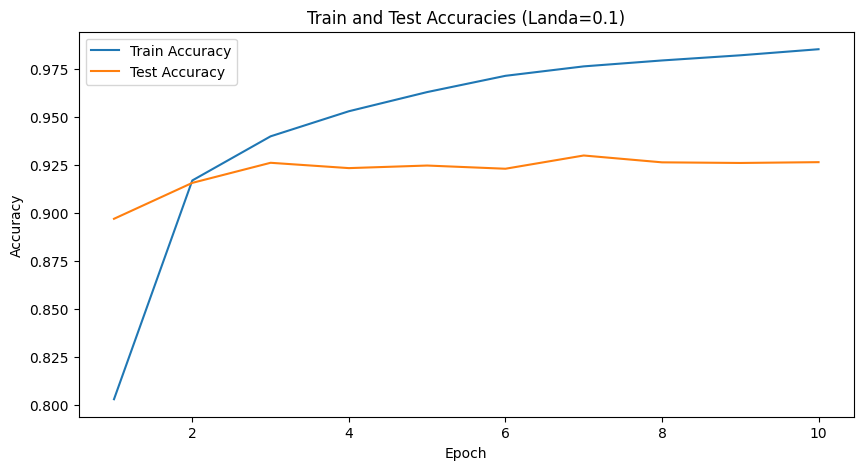

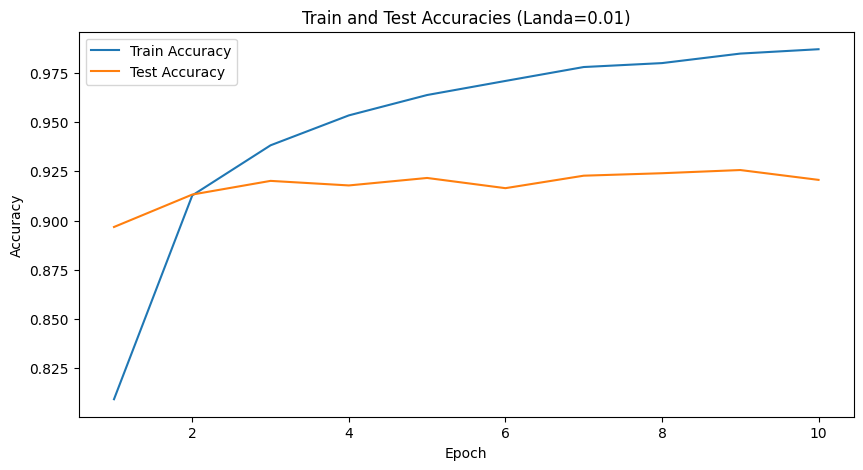

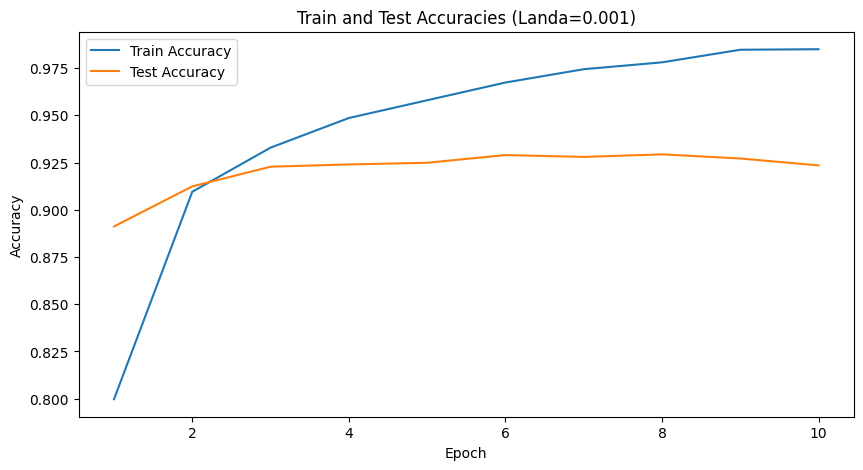

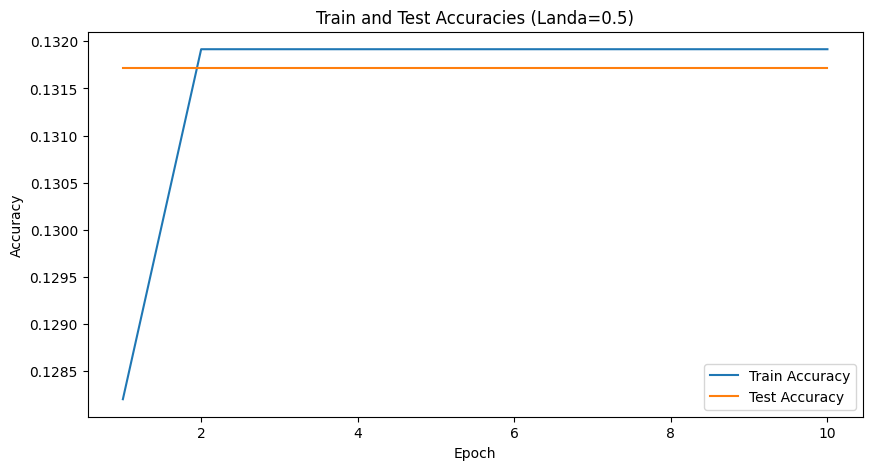

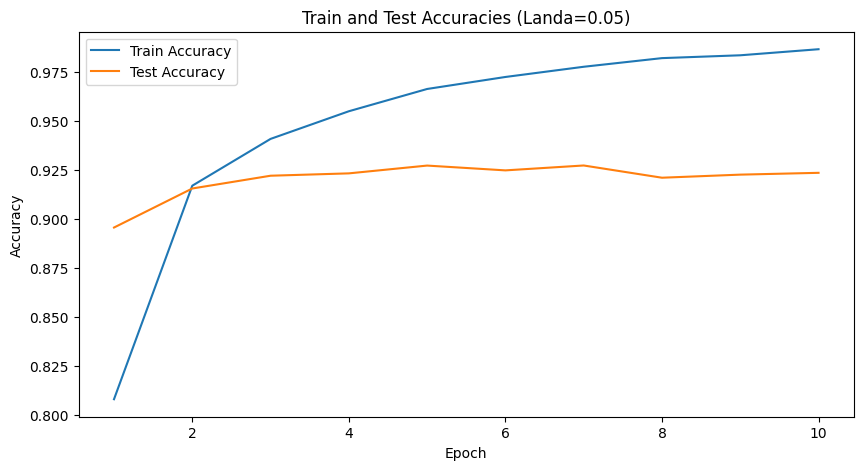

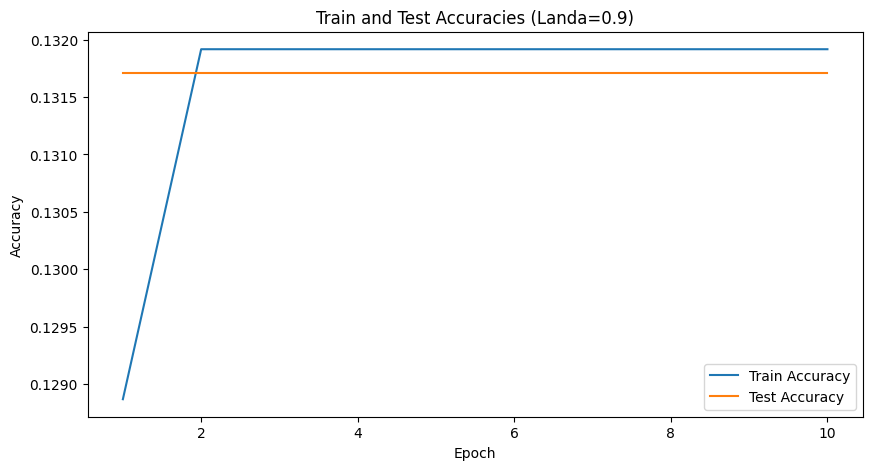

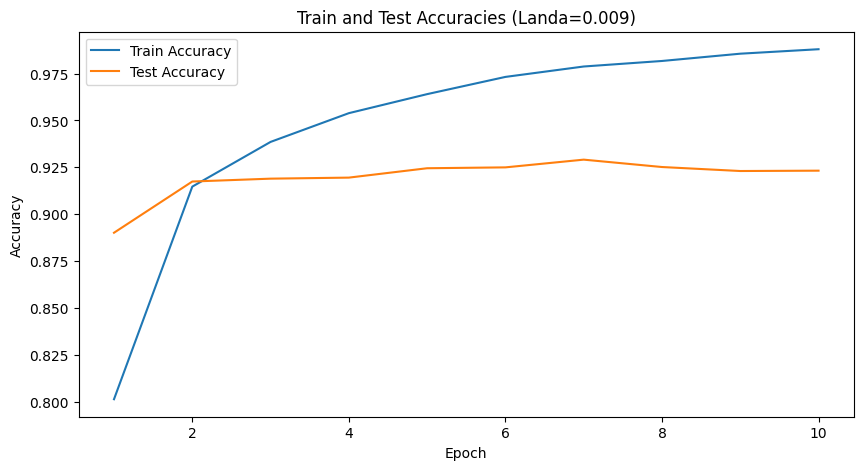

Best Landa: 0.1
Best Test Accuracy: 0.9264


In [ ]:
num_epochs = 10
margin = 0.005
landa_values = [0.1, 0.01, 0.001, 0.5, 0.05, 0.9, 0.009]
results = []

train_accuracies = []
test_accuracies = []

for landa in landa_values:
    model = DigitModel(num_features=256)
    criterion = nn.CrossEntropyLoss()
    triplet_loss = TripletLoss(margin=margin)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_accuracy_values = []
    test_accuracy_values = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy, train_triplet_loss, train_cross_entropy_loss = train(model, train_loader, criterion, triplet_loss, optimizer, landa)
        test_accuracy, test_triplet_loss, test_cross_entropy_loss, test_total_loss = evaluate(model, test_loader, criterion, triplet_loss)

        train_accuracy_values.append(train_accuracy)
        test_accuracy_values.append(test_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Accuracy: {train_accuracy:.4f} - Test Accuracy: {test_accuracy:.4f}")
        print(f"Train Triplet Loss: {train_triplet_loss:.4f} - Test Triplet Loss: {test_triplet_loss:.4f}")
        print(f"Train Cross Entropy Loss: {train_cross_entropy_loss:.4f} - Test Cross Entropy Loss: {test_cross_entropy_loss:.4f}")
        print(f"Train Total Loss: {train_loss:.4f} - Test Total Loss: {test_total_loss:.4f}")
        print()

    train_accuracies.append(train_accuracy_values)
    test_accuracies.append(test_accuracy_values)

    results.append({
        'landa': landa,
        'train_accuracy': train_accuracy_values,
        'test_accuracy': test_accuracy_values
    })

    landa = result['landa']
    train_accuracy_values = result['train_accuracy']
    test_accuracy_values = result['test_accuracy']

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_accuracy_values, label='Train Accuracy')
    plt.plot(range(1, num_epochs+1), test_accuracy_values, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Train and Test Accuracies (Landa={landa})')
    plt.legend()
    plt.show()

best_landa_index = max(range(len(results)), key=lambda i: results[i]['test_accuracy'][-1])
best_landa = landa_values[best_landa_index]
best_test_accuracy = results[best_landa_index]['test_accuracy'][-1]

print(f"Best Landa: {best_landa}")
print(f"Best Test Accuracy: {best_test_accuracy:.4f}")


In [ ]:
#Part3

Epoch 1/10
Train Loss: 0.8712 - Missing-Test Loss: 2.0612
Train Accuracy: 0.7962 - Missing-Test Accuracy: 0.8603
Train Triplet Loss: 1.9563 - Missing-Test Triplet Loss: 1.5691
Train Cross Entropy Loss: 0.6756 - Missing-Test Cross Entropy Loss: 0.4921
Train Total Loss: 0.8712 - Missing-Test Total Loss: 2.0612

Epoch 2/10
Train Loss: 0.3683 - Missing-Test Loss: 2.2091
Train Accuracy: 0.9184 - Missing-Test Accuracy: 0.8901
Train Triplet Loss: 0.9640 - Missing-Test Triplet Loss: 1.8472
Train Cross Entropy Loss: 0.2719 - Missing-Test Cross Entropy Loss: 0.3619
Train Total Loss: 0.3683 - Missing-Test Total Loss: 2.2091

Epoch 3/10
Train Loss: 0.2571 - Missing-Test Loss: 2.6730
Train Accuracy: 0.9411 - Missing-Test Accuracy: 0.9106
Train Triplet Loss: 0.6176 - Missing-Test Triplet Loss: 2.3754
Train Cross Entropy Loss: 0.1954 - Missing-Test Cross Entropy Loss: 0.2976
Train Total Loss: 0.2571 - Missing-Test Total Loss: 2.6730

Epoch 4/10
Train Loss: 0.1943 - Missing-Test Loss: 2.4869
Train Acc

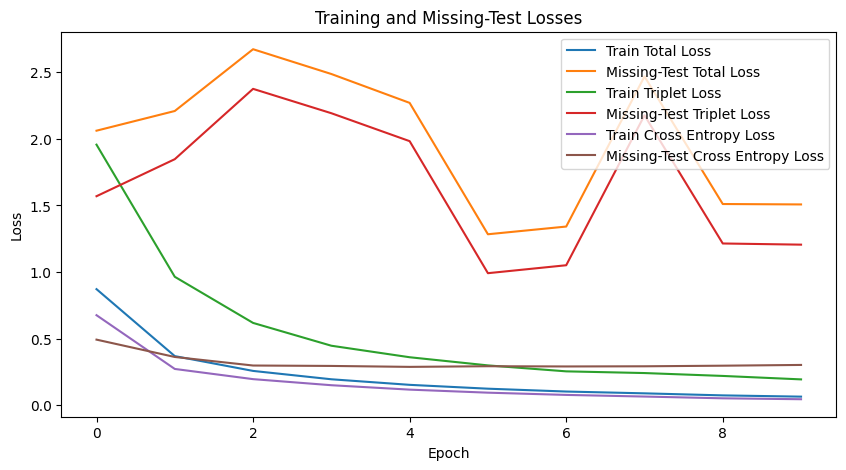

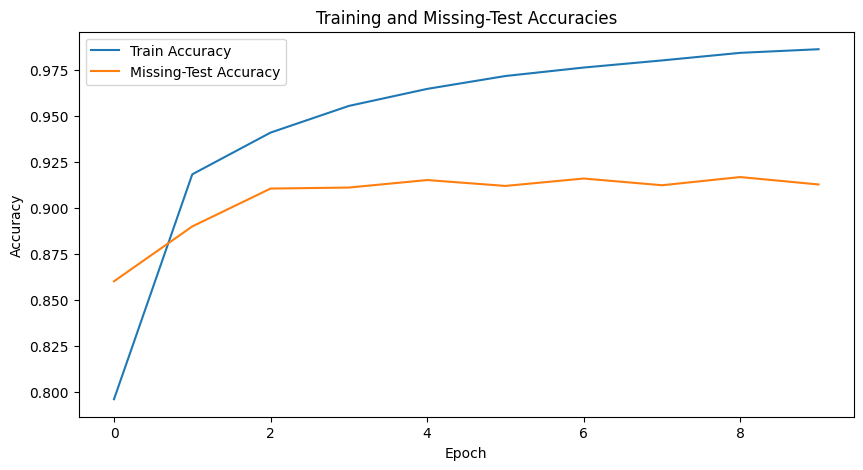

In [ ]:
class DigitModel(nn.Module):
    def __init__(self, num_features):
        super(DigitModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(64 * 4 * 4 + num_features, 128)
        self.output_layer = nn.Linear(128, 10)

    def forward(self, images, features):
        cnn_output = self.cnn(images)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)
        combined = torch.cat((cnn_output, features), dim=1)
        f = F.relu(self.fc(combined))
        output = self.output_layer(f)
        return f, output

class TripletLoss(nn.Module):
    def __init__(self, margin: float = 0.005, device=torch.device('cpu')):
        super().__init__()
        self.margin = torch.tensor(margin)
        self.device = device

    def forward(self, embeddings, labels):
        dp, dn = self.batch_hard_triplet_loss(embeddings, labels)
        triplet_loss = torch.mean(torch.clamp(dp - dn + self.margin, min=0))
        return triplet_loss

    def batch_hard_triplet_loss(self, embeddings, labels):
        dists = self.euclidean_dist(embeddings, embeddings)

        same_identity_mask = torch.eq(labels[:, None], labels[None, :])
        negative_mask = torch.logical_not(same_identity_mask)
        positive_mask = torch.logical_xor(same_identity_mask, torch.eye(labels.shape[0], dtype=torch.bool).to(self.device))

        dp, _ = torch.max(dists * positive_mask.int(), dim=1)

        dn = torch.zeros_like(dp)
        for i in range(dists.shape[0]):
            dn[i] = torch.min(dists[i, :][negative_mask[i, :]])

        return dp, dn

    def all_diffs(self, a, b):
        return a[:, None] - b[None, :]

    def euclidean_dist(self, embed1, embed2):
        diffs = self.all_diffs(embed1, embed2)
        t1 = torch.square(diffs)
        t2 = torch.sum(t1, dim=-1)
        return torch.sqrt(t2 + 1e-12)


def train(model, train_loader, criterion, triplet_loss, optimizer, landa):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    for batch_idx, (images, features, domain_labels, digit_labels) in enumerate(train_loader):
        optimizer.zero_grad()
        f, output = model(images, features)
        loss_ce = criterion(output, digit_labels)
        loss_triplet = triplet_loss(f, domain_labels)
        loss = loss_ce + landa * loss_triplet
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

        triplet_loss_sum += loss_triplet.item()
        cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(train_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(train_loader)
    total_loss = running_loss / len(train_loader)
    return total_loss, accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss


def evaluate(model, test_loader, criterion, triplet_loss):
    model.eval()
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    with torch.no_grad():
        for images, features, domain_labels, digit_labels in test_loader:
            f, output = model(images, features)
            loss_ce = criterion(output, digit_labels)
            loss_triplet = triplet_loss(f, domain_labels)

            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()

            triplet_loss_sum += loss_triplet.item()
            cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(test_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(test_loader)
    total_loss = (avg_triplet_loss + avg_cross_entropy_loss)
    return accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss, total_loss



model = DigitModel(num_features=256)
criterion = nn.CrossEntropyLoss()
triplet_loss = TripletLoss(margin=0.005)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = full_dataloaders['train']
missing_test_loader = full_dataloaders['test_missing']

import matplotlib.pyplot as plt

num_epochs = 10
landa = 0.1


train_losses = []
missing_test_losses = []
train_triplet_losses = []
missing_test_triplet_losses = []
train_cross_entropy_losses = []
missing_test_cross_entropy_losses = []
train_accuracies = []
missing_test_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_accuracy, train_triplet_loss, train_cross_entropy_loss = train(model, train_loader, criterion, triplet_loss, optimizer, landa)
    missing_test_accuracy, missing_test_triplet_loss, missing_test_cross_entropy_loss, missing_test_total_loss = evaluate(model, missing_test_loader, criterion, triplet_loss)

    train_losses.append(train_loss)
    missing_test_losses.append(missing_test_total_loss)
    train_triplet_losses.append(train_triplet_loss)
    missing_test_triplet_losses.append(missing_test_triplet_loss)
    train_cross_entropy_losses.append(train_cross_entropy_loss)
    missing_test_cross_entropy_losses.append(missing_test_cross_entropy_loss)
    train_accuracies.append(train_accuracy)
    missing_test_accuracies.append(missing_test_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} - Missing-Test Loss: {missing_test_total_loss:.4f}")
    print(f"Train Accuracy: {train_accuracy:.4f} - Missing-Test Accuracy: {missing_test_accuracy:.4f}")
    print(f"Train Triplet Loss: {train_triplet_loss:.4f} - Missing-Test Triplet Loss: {missing_test_triplet_loss:.4f}")
    print(f"Train Cross Entropy Loss: {train_cross_entropy_loss:.4f} - Missing-Test Cross Entropy Loss: {missing_test_cross_entropy_loss:.4f}")
    print(f"Train Total Loss: {train_loss:.4f} - Missing-Test Total Loss: {missing_test_total_loss:.4f}")
    print()

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Total Loss')
plt.plot(missing_test_losses, label='Missing-Test Total Loss')
plt.plot(train_triplet_losses, label='Train Triplet Loss')
plt.plot(missing_test_triplet_losses, label='Missing-Test Triplet Loss')
plt.plot(train_cross_entropy_losses, label='Train Cross Entropy Loss')
plt.plot(missing_test_cross_entropy_losses, label='Missing-Test Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Missing-Test Losses')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(missing_test_accuracies, label='Missing-Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Missing-Test Accuracies')
plt.show()


In [ ]:
# Data Augmentation

Epoch 1/10
Train Loss: 0.9022 - Missing-Test Loss: 1.9925
Train Accuracy: 0.7898 - Missing-Test Accuracy: 0.8853
Train Triplet Loss: 2.0033 - Missing-Test Triplet Loss: 1.5567
Train Cross Entropy Loss: 0.7019 - Missing-Test Cross Entropy Loss: 0.4358
Train Total Loss: 0.9022 - Missing-Test Total Loss: 1.9925

Epoch 2/10
Train Loss: 0.3819 - Missing-Test Loss: 2.1057
Train Accuracy: 0.9139 - Missing-Test Accuracy: 0.9085
Train Triplet Loss: 0.9659 - Missing-Test Triplet Loss: 1.7906
Train Cross Entropy Loss: 0.2853 - Missing-Test Cross Entropy Loss: 0.3151
Train Total Loss: 0.3819 - Missing-Test Total Loss: 2.1057

Epoch 3/10
Train Loss: 0.2638 - Missing-Test Loss: 1.7142
Train Accuracy: 0.9379 - Missing-Test Accuracy: 0.9097
Train Triplet Loss: 0.5872 - Missing-Test Triplet Loss: 1.4178
Train Cross Entropy Loss: 0.2051 - Missing-Test Cross Entropy Loss: 0.2965
Train Total Loss: 0.2638 - Missing-Test Total Loss: 1.7142

Epoch 4/10
Train Loss: 0.2012 - Missing-Test Loss: 1.4869
Train Acc

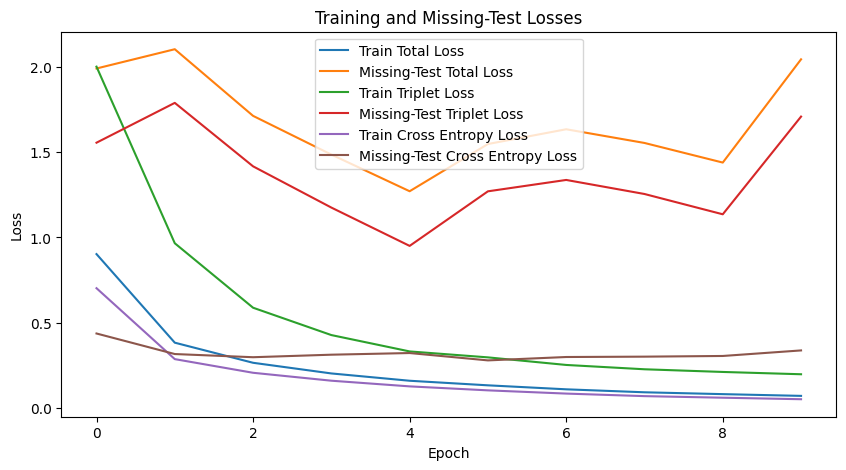

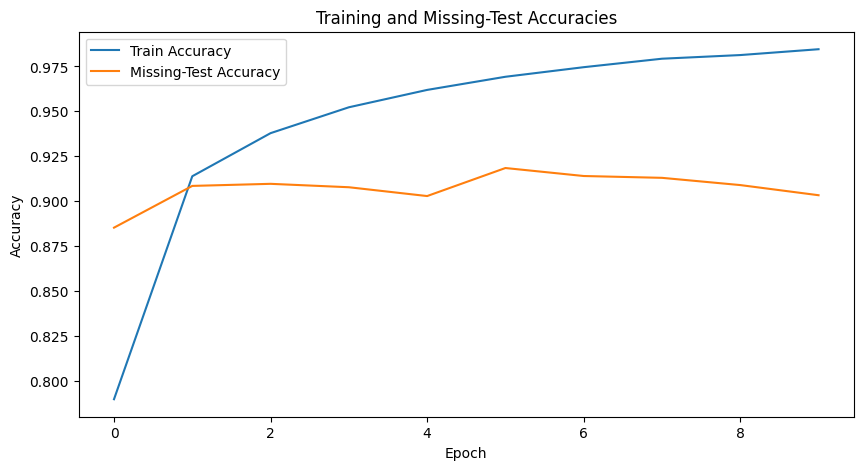

In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def get_data_loaders(file_paths, batch_size):
    train_dataset = DigitDataset(file_paths['train'], transform=transform)
    test_dataset = DigitDataset(file_paths['test'])
    missing_test_dataset = DigitDataset(file_paths['missing_test'])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    missing_test_loader = DataLoader(missing_test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, missing_test_loader



class DigitDataset(Dataset):
    def __init__(self, file_path, transform=None):
        data = np.load(file_path)
        self.images = data['images']
        self.features = data['features']
        self.domain_labels = data['domain_labels']
        self.digit_labels = data['digit_labels']
        self.transform = transform

    def __getitem__(self, index):
        image = self.images[index]
        feature = self.features[index]
        domain_label = self.domain_labels[index]
        digit_label = self.digit_labels[index]

        if self.transform:
            image = self.transform(image)

        return image, feature, domain_label, digit_label

    def __len__(self):
        return len(self.images)


class DigitModel(nn.Module):
    def __init__(self, num_features):
        super(DigitModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(64 * 4 * 4 + num_features, 128)
        self.output_layer = nn.Linear(128, 10)

    def forward(self, images, features):
        cnn_output = self.cnn(images)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)
        combined = torch.cat((cnn_output, features), dim=1)
        f = F.relu(self.fc(combined))
        output = self.output_layer(f)
        return f, output


class TripletLoss(nn.Module):
    def __init__(self, margin: float = 0.005, device=torch.device('cpu')):
        super().__init__()
        self.margin = torch.tensor(margin)
        self.device = device

    def forward(self, embeddings, labels):
        dp, dn = self.batch_hard_triplet_loss(embeddings, labels)
        triplet_loss = torch.mean(torch.clamp(dp - dn + self.margin, min=0))
        return triplet_loss

    def batch_hard_triplet_loss(self, embeddings, labels):
        dists = self.euclidean_dist(embeddings, embeddings)

        same_identity_mask = torch.eq(labels[:, None], labels[None, :])
        negative_mask = torch.logical_not(same_identity_mask)
        positive_mask = torch.logical_xor(same_identity_mask, torch.eye(labels.shape[0], dtype=torch.bool).to(self.device))

        dp, _ = torch.max(dists * positive_mask.int(), dim=1)

        dn = torch.zeros_like(dp)
        for i in range(dists.shape[0]):
            dn[i] = torch.min(dists[i, :][negative_mask[i, :]])

        return dp, dn

    def all_diffs(self, a, b):
        return a[:, None] - b[None, :]

    def euclidean_dist(self, embed1, embed2):
        diffs = self.all_diffs(embed1, embed2)
        t1 = torch.square(diffs)
        t2 = torch.sum(t1, dim=-1)
        return torch.sqrt(t2 + 1e-12)


def train(model, train_loader, criterion, triplet_loss, optimizer, landa):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    for batch_idx, (images, features, domain_labels, digit_labels) in enumerate(train_loader):
        optimizer.zero_grad()
        f, output = model(images, features)
        loss_ce = criterion(output, digit_labels)
        loss_triplet = triplet_loss(f, domain_labels)
        loss = loss_ce + landa * loss_triplet
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

        triplet_loss_sum += loss_triplet.item()
        cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(train_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(train_loader)
    total_loss = running_loss / len(train_loader)
    return total_loss, accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss


def evaluate(model, test_loader, criterion, triplet_loss):
    model.eval()
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    with torch.no_grad():
        for images, features, domain_labels, digit_labels in test_loader:
            f, output = model(images, features)
            loss_ce = criterion(output, digit_labels)
            loss_triplet = triplet_loss(f, domain_labels)

            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()

            triplet_loss_sum += loss_triplet.item()
            cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(test_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(test_loader)
    total_loss = (avg_triplet_loss + avg_cross_entropy_loss)
    return accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss, total_loss


model = DigitModel(num_features=256)
criterion = nn.CrossEntropyLoss()
triplet_loss = TripletLoss(margin=0.005)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = full_dataloaders['train']
missing_test_loader = full_dataloaders['test_missing']

import matplotlib.pyplot as plt

num_epochs = 10
landa = 0.1

train_losses = []
missing_test_losses = []
train_triplet_losses = []
missing_test_triplet_losses = []
train_cross_entropy_losses = []
missing_test_cross_entropy_losses = []
train_accuracies = []
missing_test_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_accuracy, train_triplet_loss, train_cross_entropy_loss = train(model, train_loader, criterion, triplet_loss, optimizer, landa)
    missing_test_accuracy, missing_test_triplet_loss, missing_test_cross_entropy_loss, missing_test_total_loss = evaluate(model, missing_test_loader, criterion, triplet_loss)

    train_losses.append(train_loss)
    missing_test_losses.append(missing_test_total_loss)
    train_triplet_losses.append(train_triplet_loss)
    missing_test_triplet_losses.append(missing_test_triplet_loss)
    train_cross_entropy_losses.append(train_cross_entropy_loss)
    missing_test_cross_entropy_losses.append(missing_test_cross_entropy_loss)
    train_accuracies.append(train_accuracy)
    missing_test_accuracies.append(missing_test_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} - Missing-Test Loss: {missing_test_total_loss:.4f}")
    print(f"Train Accuracy: {train_accuracy:.4f} - Missing-Test Accuracy: {missing_test_accuracy:.4f}")
    print(f"Train Triplet Loss: {train_triplet_loss:.4f} - Missing-Test Triplet Loss: {missing_test_triplet_loss:.4f}")
    print(f"Train Cross Entropy Loss: {train_cross_entropy_loss:.4f} - Missing-Test Cross Entropy Loss: {missing_test_cross_entropy_loss:.4f}")
    print(f"Train Total Loss: {train_loss:.4f} - Missing-Test Total Loss: {missing_test_total_loss:.4f}")
    print()

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Total Loss')
plt.plot(missing_test_losses, label='Missing-Test Total Loss')
plt.plot(train_triplet_losses, label='Train Triplet Loss')
plt.plot(missing_test_triplet_losses, label='Missing-Test Triplet Loss')
plt.plot(train_cross_entropy_losses, label='Train Cross Entropy Loss')
plt.plot(missing_test_cross_entropy_losses, label='Missing-Test Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Missing-Test Losses')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(missing_test_accuracies, label='Missing-Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Missing-Test Accuracies')
plt.show()

In [ ]:
# Ensemble

In [ ]:
import torch.optim as optim
import torch.nn.functional as F

class DigitModel(nn.Module):
    def __init__(self, num_features):
        super(DigitModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(64 * 4 * 4 + num_features, 128)
        self.output_layer = nn.Linear(128, 10)

    def forward(self, images, features):
        cnn_output = self.cnn(images)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)
        combined = torch.cat((cnn_output, features), dim=1)
        f = F.relu(self.fc(combined))
        output = self.output_layer(f)
        return f, output

class TripletLoss(nn.Module):
    def __init__(self, margin: float = 0.005, device=torch.device('cpu')):
        super().__init__()
        self.margin = torch.tensor(margin)
        self.device = device

    def forward(self, embeddings, labels):
        dp, dn = self.batch_hard_triplet_loss(embeddings, labels)
        triplet_loss = torch.mean(torch.clamp(dp - dn + self.margin, min=0))
        return triplet_loss

    def batch_hard_triplet_loss(self, embeddings, labels):
        dists = self.euclidean_dist(embeddings, embeddings)

        same_identity_mask = torch.eq(labels[:, None], labels[None, :])
        negative_mask = torch.logical_not(same_identity_mask)
        positive_mask = torch.logical_xor(same_identity_mask, torch.eye(labels.shape[0], dtype=torch.bool).to(self.device))

        dp, _ = torch.max(dists * positive_mask.int(), dim=1)

        dn = torch.zeros_like(dp)
        for i in range(dists.shape[0]):
            dn[i] = torch.min(dists[i, :][negative_mask[i, :]])

        return dp, dn

    def all_diffs(self, a, b):
        return a[:, None] - b[None, :]

    def euclidean_dist(self, embed1, embed2):
        diffs = self.all_diffs(embed1, embed2)
        t1 = torch.square(diffs)
        t2 = torch.sum(t1, dim=-1)
        return torch.sqrt(t2 + 1e-12)

def train(model, train_loader, criterion, triplet_loss, optimizer, landa):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    for batch_idx, (images, features, domain_labels, digit_labels) in enumerate(train_loader):
        optimizer.zero_grad()
        f, output = model(images, features)
        loss_ce = criterion(output, digit_labels)
        loss_triplet = triplet_loss(f, domain_labels)
        loss = loss_ce + landa * loss_triplet
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

        triplet_loss_sum += loss_triplet.item()
        cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(train_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(train_loader)
    total_loss = running_loss / len(train_loader)
    return total_loss, accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss

def evaluate(model, test_loader, criterion, triplet_loss):
    model.eval()
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    with torch.no_grad():
        for images, features, domain_labels, digit_labels in test_loader:
            f, output = model(images, features)
            loss_ce = criterion(output, digit_labels)
            loss_triplet = triplet_loss(f, domain_labels)

            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()

            triplet_loss_sum += loss_triplet.item()
            cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(test_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(test_loader)
    total_loss = (avg_triplet_loss + avg_cross_entropy_loss)
    return accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss, total_loss

def ensemble_evaluate(models, test_loader, criterion, triplet_loss):
    model_outputs = []
    model_labels = []

    for model in models:
        model.eval()
        outputs = []
        labels = []

        with torch.no_grad():
            for images, features, domain_labels, digit_labels in test_loader:
                f, output = model(images, features)
                outputs.append(output)
                labels.append(digit_labels)

        model_outputs.append(torch.cat(outputs))
        model_labels.append(torch.cat(labels))

    ensemble_outputs = torch.stack(model_outputs)
    ensemble_labels = torch.stack(model_labels)

    final_output = torch.mean(ensemble_outputs, dim=0)
    _, predicted = torch.max(final_output, 1)
    total = ensemble_labels.size(0)
    correct = (predicted == ensemble_labels).sum().item()
    accuracy = correct / total

    loss_ce = criterion(final_output, ensemble_labels)
    loss_triplet = triplet_loss(final_output, ensemble_labels)

    return accuracy, loss_triplet.item(), loss_ce.item(), (loss_triplet + loss_ce).item()

ensemble_models = []
num_models = 5

for _ in range(num_models):
    model = DigitModel(num_features=256)
    ensemble_models.append(model)

criterion = nn.CrossEntropyLoss()
triplet_loss = TripletLoss(margin=0.005)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = full_dataloaders['train']
missing_test_loader = full_dataloaders['test_missing']

num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_accuracy, train_triplet_loss, train_cross_entropy_loss = train(model, train_loader, criterion, triplet_loss, optimizer, landa=0.1)
    test_accuracy, test_triplet_loss, test_cross_entropy_loss, test_total_loss = evaluate(model, missing_test_loader, criterion, triplet_loss)

    print(f"Epoch: {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | Train Triplet Loss: {train_triplet_loss:.4f} | Train Cross-Entropy Loss: {train_cross_entropy_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f} | Test Triplet Loss: {test_triplet_loss:.4f} | Test Cross-Entropy Loss: {test_cross_entropy_loss:.4f} | Test Total Loss: {test_total_loss:.4f}")
    print()

ensemble_accuracy, ensemble_triplet_loss, ensemble_cross_entropy_loss, ensemble_total_loss = ensemble_evaluate(ensemble_models, missing_test_loader, criterion, triplet_loss)

print(f"Ensemble Accuracy: {ensemble_accuracy:.4f} | Ensemble Triplet Loss: {ensemble_triplet_loss:.4f} | Ensemble Cross-Entropy Loss: {ensemble_cross_entropy_loss:.4f} | Ensemble Total Loss: {ensemble_total_loss:.4f}")


Epoch: 1/10
Train Loss: 0.8996 | Train Accuracy: 0.7933 | Train Triplet Loss: 2.0537 | Train Cross-Entropy Loss: 0.6942
Test Accuracy: 0.8851 | Test Triplet Loss: 2.6904 | Test Cross-Entropy Loss: 0.4198 | Test Total Loss: 3.1102

Epoch: 2/10
Train Loss: 0.3833 | Train Accuracy: 0.9140 | Train Triplet Loss: 0.9597 | Train Cross-Entropy Loss: 0.2873
Test Accuracy: 0.9014 | Test Triplet Loss: 1.6622 | Test Cross-Entropy Loss: 0.3301 | Test Total Loss: 1.9923

Epoch: 3/10
Train Loss: 0.2656 | Train Accuracy: 0.9375 | Train Triplet Loss: 0.5803 | Train Cross-Entropy Loss: 0.2076
Test Accuracy: 0.8990 | Test Triplet Loss: 2.1040 | Test Cross-Entropy Loss: 0.3222 | Test Total Loss: 2.4263

Epoch: 4/10
Train Loss: 0.2053 | Train Accuracy: 0.9511 | Train Triplet Loss: 0.4291 | Train Cross-Entropy Loss: 0.1624
Test Accuracy: 0.9186 | Test Triplet Loss: 1.7141 | Test Cross-Entropy Loss: 0.2795 | Test Total Loss: 1.9936

Epoch: 5/10
Train Loss: 0.1637 | Train Accuracy: 0.9598 | Train Triplet Loss

ValueError: ignored

In [ ]:
# Change Architecture - batch normalization layers + Adding one fully connected layer

In [ ]:
class DigitModel(nn.Module):
    def __init__(self, num_features):
        super(DigitModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc1 = nn.Linear(128 * 4 * 4 + num_features, 256)
        self.fc2 = nn.Linear(256, 128)
        self.output_layer = nn.Linear(128, 10)

    def forward(self, images, features):
        cnn_output = self.cnn(images)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)
        combined = torch.cat((cnn_output, features), dim=1)
        f = F.relu(self.fc1(combined))
        f = F.relu(self.fc2(f))
        output = self.output_layer(f)
        return f, output


class TripletLoss(nn.Module):
    def __init__(self, margin: float = 0.005, device=torch.device('cpu')):
        super().__init__()
        self.margin = torch.tensor(margin)
        self.device = device

    def forward(self, embeddings, labels):
        dp, dn = self.batch_hard_triplet_loss(embeddings, labels)
        triplet_loss = torch.mean(torch.clamp(dp - dn + self.margin, min=0))
        return triplet_loss

    def batch_hard_triplet_loss(self, embeddings, labels):
        dists = self.euclidean_dist(embeddings, embeddings)

        same_identity_mask = torch.eq(labels[:, None], labels[None, :])
        negative_mask = torch.logical_not(same_identity_mask)
        positive_mask = torch.logical_xor(same_identity_mask, torch.eye(labels.shape[0], dtype=torch.bool).to(self.device))

        dp, _ = torch.max(dists * positive_mask.int(), dim=1)

        dn = torch.zeros_like(dp)
        for i in range(dists.shape[0]):
            dn[i] = torch.min(dists[i, :][negative_mask[i, :]])

        return dp, dn

    def all_diffs(self, a, b):
        return a[:, None] - b[None, :]

    def euclidean_dist(self, embed1, embed2):
        diffs = self.all_diffs(embed1, embed2)
        t1 = torch.square(diffs)
        t2 = torch.sum(t1, dim=-1)
        return torch.sqrt(t2 + 1e-12)


def train(model, train_loader, criterion, triplet_loss, optimizer, landa):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    for batch_idx, (images, features, domain_labels, digit_labels) in enumerate(train_loader):
        optimizer.zero_grad()
        f, output = model(images, features)
        loss_ce = criterion(output, digit_labels)
        loss_triplet = triplet_loss(f, domain_labels)
        loss = loss_ce + landa * loss_triplet
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

        triplet_loss_sum += loss_triplet.item()
        cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(train_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(train_loader)
    total_loss = running_loss / len(train_loader)
    return total_loss, accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss


def evaluate(model, test_loader, criterion, triplet_loss):
    model.eval()
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    with torch.no_grad():
        for images, features, domain_labels, digit_labels in test_loader:
            f, output = model(images, features)
            loss_ce = criterion(output, digit_labels)
            loss_triplet = triplet_loss(f, domain_labels)

            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()

            triplet_loss_sum += loss_triplet.item()
            cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(test_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(test_loader)
    total_loss = (avg_triplet_loss + avg_cross_entropy_loss)
    return accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss, total_loss


torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 64
learning_rate = 0.001
num_epochs = 10
margin = 0.005
landa = 0.1


train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']
missing_test_loader = full_dataloaders['test_missing']


num_features = 256
model = DigitModel(num_features).to(device)

criterion = nn.CrossEntropyLoss()
triplet_loss = TripletLoss(margin, device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_loss, train_accuracy, avg_triplet_loss, avg_cross_entropy_loss = train(model, train_loader, criterion, triplet_loss, optimizer, landa)
    test_accuracy, test_triplet_loss, test_cross_entropy_loss, test_total_loss = evaluate(model, test_loader, criterion, triplet_loss)
    missing_test_accuracy, missing_test_triplet_loss, missing_test_cross_entropy_loss, missing_test_total_loss = evaluate(model, missing_test_loader, criterion, triplet_loss)

    print(f"Epoch: {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.6f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Train Triplet Loss: {avg_triplet_loss:.6f} | Train Cross-Entropy Loss: {avg_cross_entropy_loss:.6f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Triplet Loss: {test_triplet_loss:.6f} | Test Cross-Entropy Loss: {test_cross_entropy_loss:.6f}")
    print(f"Test Total Loss: {test_total_loss:.6f}")
    print(f"Missing Test Accuracy: {missing_test_accuracy:.4f}")
    print(f"Missing Test Triplet Loss: {missing_test_triplet_loss:.6f} | Missing Test Cross-Entropy Loss: {missing_test_cross_entropy_loss:.6f}")
    print(f"Missing Test Total Loss: {missing_test_total_loss:.6f}")
    print("--------------------------------------------------------------")


Epoch: 1/10
Train Loss: 0.791301 | Train Accuracy: 0.7995
Train Triplet Loss: 1.498882 | Train Cross-Entropy Loss: 0.641412
Test Accuracy: 0.8742
Test Triplet Loss: 1.374264 | Test Cross-Entropy Loss: 0.394752
Test Total Loss: 1.769016
Missing Test Accuracy: 0.8730
Missing Test Triplet Loss: 1.347936 | Missing Test Cross-Entropy Loss: 0.397804
Missing Test Total Loss: 1.745740
--------------------------------------------------------------
Epoch: 2/10
Train Loss: 0.324421 | Train Accuracy: 0.9154
Train Triplet Loss: 0.536924 | Train Cross-Entropy Loss: 0.270729
Test Accuracy: 0.9193
Test Triplet Loss: 1.016719 | Test Cross-Entropy Loss: 0.264521
Test Total Loss: 1.281240
Missing Test Accuracy: 0.9188
Missing Test Triplet Loss: 1.071541 | Missing Test Cross-Entropy Loss: 0.265174
Missing Test Total Loss: 1.336715
--------------------------------------------------------------
Epoch: 3/10
Train Loss: 0.234804 | Train Accuracy: 0.9369
Train Triplet Loss: 0.332836 | Train Cross-Entropy Loss:

In [ ]:
# adding a dropout layer and weight_decay

Epoch: 1/10
Train Loss: 1.061084 | Train Accuracy: 0.7641
Train Triplet Loss: 2.770856 | Train Cross-Entropy Loss: 0.783999
Test Accuracy: 0.8696
Test Triplet Loss: 3.051317 | Test Cross-Entropy Loss: 0.431704
Test Total Loss: 3.483021
Missing Test Accuracy: 0.8654
Missing Test Triplet Loss: 3.088393 | Missing Test Cross-Entropy Loss: 0.445021
Missing Test Total Loss: 3.533414
--------------------------------------------------------------
Epoch: 2/10
Train Loss: 0.546833 | Train Accuracy: 0.9071
Train Triplet Loss: 2.034075 | Train Cross-Entropy Loss: 0.343425
Test Accuracy: 0.9128
Test Triplet Loss: 2.371987 | Test Cross-Entropy Loss: 0.297845
Test Total Loss: 2.669832
Missing Test Accuracy: 0.9154
Missing Test Triplet Loss: 2.460015 | Missing Test Cross-Entropy Loss: 0.293173
Missing Test Total Loss: 2.753188
--------------------------------------------------------------
Epoch: 3/10
Train Loss: 0.444578 | Train Accuracy: 0.9263
Train Triplet Loss: 1.693122 | Train Cross-Entropy Loss:

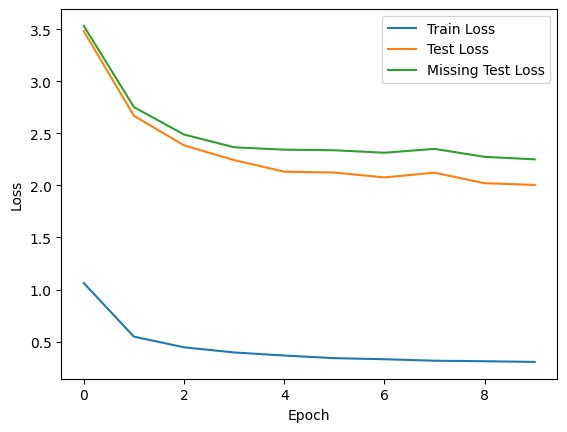

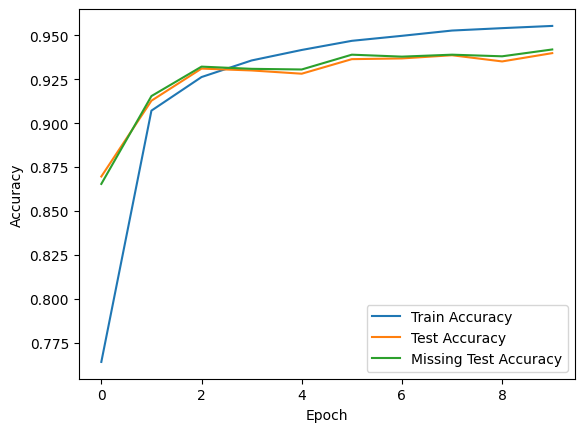

In [ ]:
class DigitModel(nn.Module):
    def __init__(self, num_features):
        super(DigitModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc1 = nn.Linear(128 * 4 * 4 + num_features, 256)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.output_layer = nn.Linear(128, 10)

    def forward(self, images, features):
        cnn_output = self.cnn(images)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)
        combined = torch.cat((cnn_output, features), dim=1)
        f = F.relu(self.fc1(combined))
        f = F.relu(self.fc2(f))
        f = self.dropout2(f)
        output = self.output_layer(f)
        return f, output


class TripletLoss(nn.Module):
    def __init__(self, margin: float = 0.005):
        super().__init__()
        self.margin = torch.tensor(margin)

    def forward(self, embeddings, labels):
        dp, dn = self.batch_hard_triplet_loss(embeddings, labels)
        triplet_loss = torch.mean(torch.clamp(dp - dn + self.margin, min=0))
        return triplet_loss

    def batch_hard_triplet_loss(self, embeddings, labels):
        dists = self.euclidean_dist(embeddings, embeddings)

        same_identity_mask = torch.eq(labels[:, None], labels[None, :])
        negative_mask = torch.logical_not(same_identity_mask)
        positive_mask = torch.logical_xor(same_identity_mask, torch.eye(labels.shape[0], dtype=torch.bool))

        dp, _ = torch.max(dists * positive_mask.int(), dim=1)

        dn = torch.zeros_like(dp)
        for i in range(dists.shape[0]):
            dn[i] = torch.min(dists[i, :][negative_mask[i, :]])

        return dp, dn

    def all_diffs(self, a, b):
        return a[:, None] - b[None, :]

    def euclidean_dist(self, embed1, embed2):
        diffs = self.all_diffs(embed1, embed2)
        t1 = torch.square(diffs)
        t2 = torch.sum(t1, dim=-1)
        return torch.sqrt(t2 + 1e-12)


def train(model, train_loader, criterion, triplet_loss, optimizer, landa):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    for batch_idx, (images, features, domain_labels, digit_labels) in enumerate(train_loader):
        optimizer.zero_grad()
        f, output = model(images, features)
        loss_ce = criterion(output, digit_labels)
        loss_triplet = triplet_loss(f, domain_labels)
        loss = loss_ce + landa * loss_triplet
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

        triplet_loss_sum += loss_triplet.item()
        cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(train_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(train_loader)
    total_loss = running_loss / len(train_loader)
    return total_loss, accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss


def evaluate(model, test_loader, criterion, triplet_loss):
    model.eval()
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    with torch.no_grad():
        for images, features, domain_labels, digit_labels in test_loader:
            f, output = model(images, features)
            loss_ce = criterion(output, digit_labels)
            loss_triplet = triplet_loss(f, domain_labels)

            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()

            triplet_loss_sum += loss_triplet.item()
            cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(test_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(test_loader)
    total_loss = (avg_triplet_loss + avg_cross_entropy_loss)
    return accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss, total_loss


torch.manual_seed(42)
device = torch.device("cpu")
batch_size = 64
learning_rate = 0.001
num_epochs = 10
margin = 0.005
landa = 0.1


train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']
missing_test_loader = full_dataloaders['test_missing']


num_features = 256
model = DigitModel(num_features).to(device)

criterion = nn.CrossEntropyLoss()
triplet_loss = TripletLoss(margin)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

train_losses = []
test_losses = []
missing_test_losses = []
train_accuracies = []
test_accuracies = []
missing_test_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_accuracy, avg_triplet_loss, avg_cross_entropy_loss = train(model, train_loader, criterion, triplet_loss, optimizer, landa)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    test_accuracy, test_triplet_loss, test_cross_entropy_loss, test_total_loss = evaluate(model, test_loader, criterion, triplet_loss)
    test_losses.append(test_total_loss)
    test_accuracies.append(test_accuracy)

    missing_test_accuracy, missing_test_triplet_loss, missing_test_cross_entropy_loss, missing_test_total_loss = evaluate(model, missing_test_loader, criterion, triplet_loss)
    missing_test_losses.append(missing_test_total_loss)
    missing_test_accuracies.append(missing_test_accuracy)

    print(f"Epoch: {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.6f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Train Triplet Loss: {avg_triplet_loss:.6f} | Train Cross-Entropy Loss: {avg_cross_entropy_loss:.6f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Triplet Loss: {test_triplet_loss:.6f} | Test Cross-Entropy Loss: {test_cross_entropy_loss:.6f}")
    print(f"Test Total Loss: {test_total_loss:.6f}")
    print(f"Missing Test Accuracy: {missing_test_accuracy:.4f}")
    print(f"Missing Test Triplet Loss: {missing_test_triplet_loss:.6f} | Missing Test Cross-Entropy Loss: {missing_test_cross_entropy_loss:.6f}")
    print(f"Missing Test Total Loss: {missing_test_total_loss:.6f}")
    print("--------------------------------------------------------------")

plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.plot(missing_test_losses, label="Missing Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.plot(missing_test_accuracies, label="Missing Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



In [ ]:
# remove maxpoolig and BatchNorm2d

Epoch: 1/10
Train Loss: 1.142948 | Train Accuracy: 0.7407
Train Triplet Loss: 2.671785 | Train Cross-Entropy Loss: 0.875770
Test Accuracy: 0.8823
Test Triplet Loss: 2.796181 | Test Cross-Entropy Loss: 0.407811
Test Total Loss: 3.203992
Missing Test Accuracy: 0.7609
Missing Test Triplet Loss: 2.369449 | Missing Test Cross-Entropy Loss: 0.802964
Missing Test Total Loss: 3.172413
--------------------------------------------------------------
Epoch: 2/10
Train Loss: 0.632503 | Train Accuracy: 0.8810
Train Triplet Loss: 2.121110 | Train Cross-Entropy Loss: 0.420392
Test Accuracy: 0.8916
Test Triplet Loss: 2.090012 | Test Cross-Entropy Loss: 0.384189
Test Total Loss: 2.474201
Missing Test Accuracy: 0.7684
Missing Test Triplet Loss: 1.737707 | Missing Test Cross-Entropy Loss: 0.798692
Missing Test Total Loss: 2.536399
--------------------------------------------------------------
Epoch: 3/10
Train Loss: 0.533624 | Train Accuracy: 0.9024
Train Triplet Loss: 1.825900 | Train Cross-Entropy Loss:

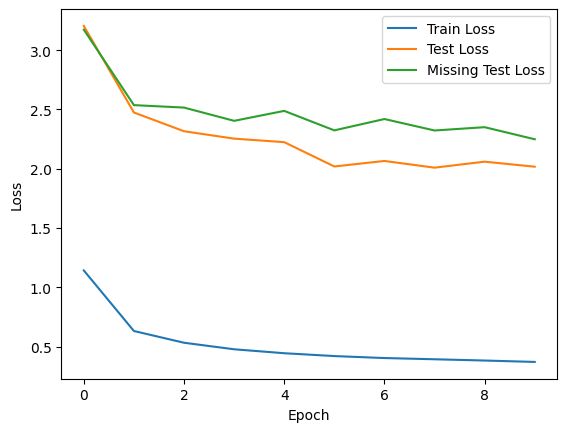

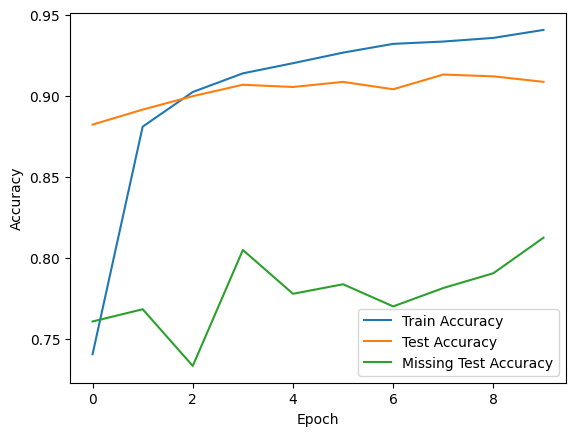

In [14]:
class DigitModel(nn.Module):
    def __init__(self, num_features):
        super(DigitModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.fc1 = nn.Linear(128 * 32 * 32 + num_features, 256)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.output_layer = nn.Linear(128, 10)

    def forward(self, images, features):
        cnn_output = self.cnn(images)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)
        combined = torch.cat((cnn_output, features), dim=1)
        f = F.relu(self.fc1(combined))
        f = F.relu(self.fc2(f))
        f = self.dropout2(f)
        output = self.output_layer(f)
        return f, output


class TripletLoss(nn.Module):
    def __init__(self, margin: float = 0.005):
        super().__init__()
        self.margin = torch.tensor(margin)

    def forward(self, embeddings, labels):
        dp, dn = self.batch_hard_triplet_loss(embeddings, labels)
        triplet_loss = torch.mean(torch.clamp(dp - dn + self.margin, min=0))
        return triplet_loss

    def batch_hard_triplet_loss(self, embeddings, labels):
        dists = self.euclidean_dist(embeddings, embeddings)

        same_identity_mask = torch.eq(labels[:, None], labels[None, :])
        negative_mask = torch.logical_not(same_identity_mask)
        positive_mask = torch.logical_xor(same_identity_mask, torch.eye(labels.shape[0], dtype=torch.bool, device=labels.device))

        dp, _ = torch.max(dists * positive_mask.int(), dim=1)

        dn = torch.zeros_like(dp)
        for i in range(dists.shape[0]):
            dn[i] = torch.min(dists[i, :][negative_mask[i, :]])

        return dp, dn

    def all_diffs(self, a, b):
        return a[:, None] - b[None, :]

    def euclidean_dist(self, embed1, embed2):
        diffs = self.all_diffs(embed1, embed2)
        t1 = torch.square(diffs)
        t2 = torch.sum(t1, dim=-1)
        return torch.sqrt(t2 + 1e-12)


def train(model, train_loader, criterion, triplet_loss, optimizer, landa, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    for batch_idx, (images, features, domain_labels, digit_labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        domain_labels = domain_labels.to(device)
        digit_labels = digit_labels.to(device)

        optimizer.zero_grad()
        f, output = model(images, features)
        loss_ce = criterion(output, digit_labels)
        loss_triplet = triplet_loss(f, domain_labels)
        loss = loss_ce + landa * loss_triplet
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

        triplet_loss_sum += loss_triplet.item()
        cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(train_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(train_loader)
    total_loss = running_loss / len(train_loader)
    return total_loss, accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss


def evaluate(model, test_loader, criterion, triplet_loss, device):
    model.eval()
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    with torch.no_grad():
        for images, features, domain_labels, digit_labels in test_loader:
            images = images.to(device)
            features = features.to(device)
            domain_labels = domain_labels.to(device)
            digit_labels = digit_labels.to(device)

            f, output = model(images, features)
            loss_ce = criterion(output, digit_labels)
            loss_triplet = triplet_loss(f, domain_labels)

            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()

            triplet_loss_sum += loss_triplet.item()
            cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(test_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(test_loader)
    total_loss = (avg_triplet_loss + avg_cross_entropy_loss)
    return accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss, total_loss


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
batch_size = 64
learning_rate = 0.001
num_epochs = 10
margin = 0.005
landa = 0.1


train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']
missing_test_loader = full_dataloaders['test_missing']


num_features = 256
model = DigitModel(num_features).to(device)

criterion = nn.CrossEntropyLoss()
triplet_loss = TripletLoss(margin)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

train_losses = []
test_losses = []
missing_test_losses = []
train_accuracies = []
test_accuracies = []
missing_test_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_accuracy, avg_triplet_loss, avg_cross_entropy_loss = train(model, train_loader, criterion, triplet_loss, optimizer, landa, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    test_accuracy, test_triplet_loss, test_cross_entropy_loss, test_total_loss = evaluate(model, test_loader, criterion, triplet_loss, device)
    test_losses.append(test_total_loss)
    test_accuracies.append(test_accuracy)

    missing_test_accuracy, missing_test_triplet_loss, missing_test_cross_entropy_loss, missing_test_total_loss = evaluate(model, missing_test_loader, criterion, triplet_loss, device)
    missing_test_losses.append(missing_test_total_loss)
    missing_test_accuracies.append(missing_test_accuracy)

    print(f"Epoch: {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.6f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Train Triplet Loss: {avg_triplet_loss:.6f} | Train Cross-Entropy Loss: {avg_cross_entropy_loss:.6f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Triplet Loss: {test_triplet_loss:.6f} | Test Cross-Entropy Loss: {test_cross_entropy_loss:.6f}")
    print(f"Test Total Loss: {test_total_loss:.6f}")
    print(f"Missing Test Accuracy: {missing_test_accuracy:.4f}")
    print(f"Missing Test Triplet Loss: {missing_test_triplet_loss:.6f} | Missing Test Cross-Entropy Loss: {missing_test_cross_entropy_loss:.6f}")
    print(f"Missing Test Total Loss: {missing_test_total_loss:.6f}")
    print("--------------------------------------------------------------")

plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.plot(missing_test_losses, label="Missing Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.plot(missing_test_accuracies, label="Missing Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [25]:
class DigitModel(nn.Module):
    def __init__(self, num_features):
        super(DigitModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc1 = nn.Linear(128 * 4 * 4 + num_features, 256)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.output_layer = nn.Linear(128, 10)

    def forward(self, images, features):
        cnn_output = self.cnn(images)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)
        combined = torch.cat((cnn_output, features), dim=1)
        f = nn.functional.relu(self.fc1(combined))
        f = nn.functional.relu(self.fc2(f))
        f = self.dropout2(f)
        output = self.output_layer(f)
        return f, output

class TripletLoss(nn.Module):
    def __init__(self, margin: float = 0.005):
        super().__init__()
        self.margin = torch.tensor(margin)

    def forward(self, embeddings, labels):
        dp, dn = self.batch_hard_triplet_loss(embeddings, labels)
        triplet_loss = torch.mean(torch.clamp(dp - dn + self.margin, min=0))
        return triplet_loss

    def batch_hard_triplet_loss(self, embeddings, labels):
        dists = self.euclidean_dist(embeddings, embeddings)

        same_identity_mask = torch.eq(labels[:, None], labels[None, :])
        negative_mask = torch.logical_not(same_identity_mask)

        positive_mask = torch.logical_xor(same_identity_mask, torch.eye(labels.shape[0], dtype=torch.bool, device=embeddings.device))

        dp, _ = torch.max(dists * positive_mask.int(), dim=1)

        dn = torch.zeros_like(dp)
        for i in range(dists.shape[0]):
            dn[i] = torch.min(dists[i, :][negative_mask[i, :]])

        return dp, dn

    def all_diffs(self, a, b):
        return a[:, None] - b[None, :]

    def euclidean_dist(self, embed1, embed2):
        diffs = self.all_diffs(embed1, embed2)
        t1 = torch.square(diffs)
        t2 = torch.sum(t1, dim=-1)
        return torch.sqrt(t2 + 1e-12)

def train(model, train_loader, criterion, triplet_loss, optimizer, landa, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    for batch_idx, (images, features, domain_labels, digit_labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        domain_labels = domain_labels.to(device)
        digit_labels = digit_labels.to(device)

        optimizer.zero_grad()
        f, output = model(images, features)
        loss_ce = criterion(output, digit_labels)
        loss_triplet = triplet_loss(f, domain_labels)
        loss = loss_ce + landa * loss_triplet
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

        triplet_loss_sum += loss_triplet.item()
        cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(train_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(train_loader)
    total_loss = running_loss / len(train_loader)
    return total_loss, accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss


def evaluate(model, test_loader, criterion, triplet_loss, device):
    model.eval()
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    with torch.no_grad():
        for images, features, domain_labels, digit_labels in test_loader:
            images = images.to(device)
            features = features.to(device)
            domain_labels = domain_labels.to(device)
            digit_labels = digit_labels.to(device)

            f, output = model(images, features)
            loss_ce = criterion(output, digit_labels)
            loss_triplet = triplet_loss(f, domain_labels)

            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()

            triplet_loss_sum += loss_triplet.item()
            cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(test_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(test_loader)
    total_loss = (avg_triplet_loss + avg_cross_entropy_loss)
    return accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss, total_loss


torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
learning_rate = 0.001
num_epochs = 10
margin = 0.005
landa = 0.1

train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']
test_missing_loader = full_dataloaders['test']

num_features = 256
model = DigitModel(num_features).to(device)

criterion = nn.CrossEntropyLoss()
triplet_loss = TripletLoss(margin)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_accuracy, avg_triplet_loss, avg_cross_entropy_loss = train(model, train_loader, criterion, triplet_loss, optimizer, landa, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    test_accuracy, test_triplet_loss, test_cross_entropy_loss, test_total_loss = evaluate(model, test_loader, criterion, triplet_loss, device)
    test_losses.append(test_total_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch: {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.6f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Train Triplet Loss: {avg_triplet_loss:.6f} | Train Cross-Entropy Loss: {avg_cross_entropy_loss:.6f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Triplet Loss: {test_triplet_loss:.6f} | Test Cross-Entropy Loss: {test_cross_entropy_loss:.6f}")
    print(f"Test Total Loss: {test_total_loss:.6f}")
    print("--------------------------------------------------------------")

# Get the embeddings from the trained DigitModel
def get_embeddings(model, data_loader):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for images, features, _, digit_labels in data_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)
            _, output = model(images, features)
            embeddings.extend(output.cpu().numpy())
            labels.extend(digit_labels.cpu().numpy())
    embeddings = torch.tensor(embeddings)
    labels = torch.tensor(labels)
    return embeddings, labels

train_embeddings, train_labels = get_embeddings(model, train_loader)
test_embeddings, test_labels = get_embeddings(model, test_loader)
test_missing_embeddings, test_missing_labels = get_embeddings(model, test_missing_loader)


# Create an SVM classifier
svm_classifier = svm.SVC(kernel='linear', probability=True)
svm_classifier.fit(train_embeddings, train_labels)

# Evaluate the SVM classifier
svm_predictions = svm_classifier.predict(test_embeddings)
svm_accuracy = (svm_predictions == test_labels.numpy()).mean()

svm_missing_predictions = svm_classifier.predict(test_missing_embeddings)
svm_missing_accuracy = (svm_missing_predictions == test_missing_labels.numpy()).mean()



Epoch: 1/10
Train Loss: 1.056712 | Train Accuracy: 0.7759
Train Triplet Loss: 2.947136 | Train Cross-Entropy Loss: 0.761998
Test Accuracy: 0.8956
Test Triplet Loss: 3.306224 | Test Cross-Entropy Loss: 0.363686
Test Total Loss: 3.669909
--------------------------------------------------------------
Epoch: 2/10
Train Loss: 0.551824 | Train Accuracy: 0.9090
Train Triplet Loss: 2.149892 | Train Cross-Entropy Loss: 0.336835
Test Accuracy: 0.9206
Test Triplet Loss: 2.582999 | Test Cross-Entropy Loss: 0.271591
Test Total Loss: 2.854589
--------------------------------------------------------------
Epoch: 3/10
Train Loss: 0.450690 | Train Accuracy: 0.9261
Train Triplet Loss: 1.765552 | Train Cross-Entropy Loss: 0.274134
Test Accuracy: 0.9237
Test Triplet Loss: 2.172904 | Test Cross-Entropy Loss: 0.259281
Test Total Loss: 2.432185
--------------------------------------------------------------
Epoch: 4/10
Train Loss: 0.396125 | Train Accuracy: 0.9369
Train Triplet Loss: 1.579928 | Train Cross-En

<ipython-input-25-a4d7c8fcb97e>:196: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  embeddings = torch.tensor(embeddings)


NameError: ignored

In [41]:
from sklearn.svm import SVC

class DigitModel(nn.Module):
    def __init__(self, num_features):
        super(DigitModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc1 = nn.Linear(128 * 4 * 4 + num_features, 256)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.output_layer = nn.Linear(128, 10)

    def forward(self, images, features):
        cnn_output = self.cnn(images)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)
        combined = torch.cat((cnn_output, features), dim=1)
        f = F.relu(self.fc1(combined))
        f = F.relu(self.fc2(f))
        f = self.dropout2(f)
        output = self.output_layer(f)
        return f, output


class TripletLoss(nn.Module):
    def __init__(self, margin: float = 0.005):
        super().__init__()
        self.margin = torch.tensor(margin)

    def forward(self, embeddings, labels):
        dp, dn = self.batch_hard_triplet_loss(embeddings, labels)
        triplet_loss = torch.mean(torch.clamp(dp - dn + self.margin, min=0))
        return triplet_loss

    def batch_hard_triplet_loss(self, embeddings, labels):
        dists = self.euclidean_dist(embeddings, embeddings)

        same_identity_mask = torch.eq(labels[:, None], labels[None, :])
        negative_mask = torch.logical_not(same_identity_mask)

        positive_mask = torch.logical_xor(same_identity_mask, torch.eye(labels.shape[0], dtype=torch.bool).to(embeddings.device))

        dp, _ = torch.max(dists * positive_mask.int(), dim=1)

        dn = torch.zeros_like(dp)
        for i in range(dists.shape[0]):
            dn[i] = torch.min(dists[i, :][negative_mask[i, :]])

        return dp, dn

    def all_diffs(self, a, b):
        return a[:, None] - b[None, :]

    def euclidean_dist(self, embed1, embed2):
        diffs = self.all_diffs(embed1, embed2)
        t1 = torch.square(diffs)
        t2 = torch.sum(t1, dim=-1)
        return torch.sqrt(t2 + 1e-12)


def train(model, train_loader, criterion, triplet_loss, optimizer, landa):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    for batch_idx, (images, features, domain_labels, digit_labels) in enumerate(train_loader):
        images, features, domain_labels, digit_labels = images.to(device), features.to(device), domain_labels.to(device), digit_labels.to(device)
        optimizer.zero_grad()
        f, output = model(images, features)
        loss_ce = criterion(output, digit_labels)
        loss_triplet = triplet_loss(f, domain_labels)
        loss = loss_ce + landa * loss_triplet
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

        triplet_loss_sum += loss_triplet.item()
        cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(train_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(train_loader)
    total_loss = running_loss / len(train_loader)
    return total_loss, accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss


def evaluate(model, test_loader, criterion, triplet_loss):
    model.eval()
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    with torch.no_grad():
        for images, features, domain_labels, digit_labels in test_loader:
            images, features, domain_labels, digit_labels = images.to(device), features.to(device), domain_labels.to(device), digit_labels.to(device)
            f, output = model(images, features)
            loss_ce = criterion(output, digit_labels)
            loss_triplet = triplet_loss(f, domain_labels)

            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()

            triplet_loss_sum += loss_triplet.item()
            cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(test_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(test_loader)
    total_loss = (avg_triplet_loss + avg_cross_entropy_loss)
    return accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss, total_loss


torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
learning_rate = 0.001
num_epochs = 10
margin = 0.005
landa = 0.1

train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']
missing_test_loader = full_dataloaders['test_missing']

num_features = 256
model = DigitModel(num_features).to(device)

criterion = nn.CrossEntropyLoss()
triplet_loss = TripletLoss(margin)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

train_losses = []
test_losses = []
missing_test_losses = []
train_accuracies = []
test_accuracies = []
missing_test_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_accuracy, avg_triplet_loss, avg_cross_entropy_loss = train(model, train_loader, criterion, triplet_loss, optimizer, landa)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    test_accuracy, test_triplet_loss, test_cross_entropy_loss, test_total_loss = evaluate(model, test_loader, criterion, triplet_loss)
    test_losses.append(test_total_loss)
    test_accuracies.append(test_accuracy)

    missing_test_accuracy, missing_test_triplet_loss, missing_test_cross_entropy_loss, missing_test_total_loss = evaluate(model, missing_test_loader, criterion, triplet_loss)
    missing_test_losses.append(missing_test_total_loss)
    missing_test_accuracies.append(missing_test_accuracy)

    print(f"Epoch: {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.6f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Train Triplet Loss: {avg_triplet_loss:.6f} | Train Cross-Entropy Loss: {avg_cross_entropy_loss:.6f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Triplet Loss: {test_triplet_loss:.6f} | Test Cross-Entropy Loss: {test_cross_entropy_loss:.6f}")
    print(f"Test Total Loss: {test_total_loss:.6f}")
    print(f"Missing Test Accuracy: {missing_test_accuracy:.4f}")
    print(f"Missing Test Triplet Loss: {missing_test_triplet_loss:.6f} | Missing Test Cross-Entropy Loss: {missing_test_cross_entropy_loss:.6f}")
    print(f"Missing Test Total Loss: {missing_test_total_loss:.6f}")
    print("--------------------------------------------------------------")


Epoch: 1/10
Train Loss: 1.059495 | Train Accuracy: 0.7744
Train Triplet Loss: 2.966826 | Train Cross-Entropy Loss: 0.762813
Test Accuracy: 0.9040
Test Triplet Loss: 3.139893 | Test Cross-Entropy Loss: 0.353025
Test Total Loss: 3.492918
Missing Test Accuracy: 0.9026
Missing Test Triplet Loss: 3.182326 | Missing Test Cross-Entropy Loss: 0.356091
Missing Test Total Loss: 3.538417
--------------------------------------------------------------
Epoch: 2/10
Train Loss: 0.555934 | Train Accuracy: 0.9072
Train Triplet Loss: 2.135928 | Train Cross-Entropy Loss: 0.342341
Test Accuracy: 0.9177
Test Triplet Loss: 2.594422 | Test Cross-Entropy Loss: 0.278469
Test Total Loss: 2.872891
Missing Test Accuracy: 0.9184
Missing Test Triplet Loss: 2.697171 | Missing Test Cross-Entropy Loss: 0.278179
Missing Test Total Loss: 2.975350
--------------------------------------------------------------
Epoch: 3/10
Train Loss: 0.450660 | Train Accuracy: 0.9253
Train Triplet Loss: 1.738928 | Train Cross-Entropy Loss:

In [46]:
def get_embeddings(model, data_loader):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for images, features, _, digit_labels in data_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)
            _, output = model(images, features)
            embeddings.extend(output.cpu().numpy())
            labels.extend(digit_labels.cpu().numpy())
    embeddings = torch.tensor(embeddings)
    labels = torch.tensor(labels)
    return embeddings, labels


In [47]:
train_features, train_labels = extract_features(model, train_loader)
test_features, test_labels = extract_features(model, test_loader)
missing_test_features, missing_test_labels = extract_features(model, missing_test_loader)

svm_model = SVC(C=100.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
                decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
                max_iter=-1, probability=False, random_state=None, shrinking=True,
                tol=0.001, verbose=False)
svm_model.fit(train_features, train_labels)

svm_test_accuracy = svm_model.score(test_features, test_labels)
svm_missing_test_accuracy = svm_model.score(missing_test_features, missing_test_labels)

print(f"SVM Test Accuracy: {svm_test_accuracy:.4f}")
print(f"SVM Missing Test Accuracy: {svm_missing_test_accuracy:.4f}")


SVM Test Accuracy: 0.9392
SVM Missing Test Accuracy: 0.9437


In [51]:
from sklearn.ensemble import RandomForestClassifier
model2 = RandomForestClassifier(n_estimators=200, criterion='gini', min_samples_split=5, min_samples_leaf=2, max_features='auto', bootstrap=True, n_jobs=-1, random_state=42)

In [52]:
# model2.fit(train_features, train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


AttributeError: ignored

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

y_pred = model2.predict(missing_test_features)
accuracy_score(missing_test_labels, y_pred)

NameError: ignored

In [56]:
import xgboost as xgb

dtrain = xgb.DMatrix(train_features, label=train_labels)
dtest = xgb.DMatrix(test_features, label=test_labels)
dmissing_test = xgb.DMatrix(missing_test_features, label=missing_test_labels)

params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'multi:softmax',
    'num_class': 10
}

num_rounds = 100
model_xgb = xgb.train(params, dtrain, num_rounds)
y_pred_xgb = model_xgb.predict(dmissing_test)
accuracy = accuracy_score(missing_test_labels, y_pred_xgb)
print(f"XGBoost Test Accuracy: {accuracy:.4f}")


XGBoost Test Accuracy: 0.9425


In [60]:
# change activation func

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.svm import SVC
import matplotlib.pyplot as plt

class DigitModel(nn.Module):
    def __init__(self, num_features):
        super(DigitModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc1 = nn.Linear(128 * 4 * 4 + num_features, 256)
        self.fc2 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.5)
        self.output_layer = nn.Linear(128, 10)

    def forward(self, images, features):
        cnn_output = self.cnn(images)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)
        combined = torch.cat((cnn_output, features), dim=1)
        f = F.leaky_relu(self.fc1(combined))
        f = F.leaky_relu(self.fc2(f))
        f = self.dropout(f)
        output = self.output_layer(f)
        return f, output


class TripletLoss(nn.Module):
    def __init__(self, margin: float = 0.005):
        super().__init__()
        self.margin = torch.tensor(margin)

    def forward(self, embeddings, labels):
        dp, dn = self.batch_hard_triplet_loss(embeddings, labels)
        triplet_loss = torch.mean(torch.clamp(dp - dn + self.margin, min=0))
        return triplet_loss

    def batch_hard_triplet_loss(self, embeddings, labels):
        dists = self.euclidean_dist(embeddings, embeddings)

        same_identity_mask = torch.eq(labels[:, None], labels[None, :])
        negative_mask = torch.logical_not(same_identity_mask)

        positive_mask = torch.logical_xor(same_identity_mask, torch.eye(labels.shape[0], dtype=torch.bool).to(embeddings.device))

        dp, _ = torch.max(dists * positive_mask.int(), dim=1)

        dn = torch.zeros_like(dp)
        for i in range(dists.shape[0]):
            dn[i] = torch.min(dists[i, :][negative_mask[i, :]])

        return dp, dn

    def all_diffs(self, a, b):
        return a[:, None] - b[None, :]

    def euclidean_dist(self, embed1, embed2):
        diffs = self.all_diffs(embed1, embed2)
        t1 = torch.square(diffs)
        t2 = torch.sum(t1, dim=-1)
        return torch.sqrt(t2 + 1e-12)


def train(model, train_loader, criterion, triplet_loss, optimizer, landa):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    for batch_idx, (images, features, domain_labels, digit_labels) in enumerate(train_loader):
        images, features, domain_labels, digit_labels = images.to(device), features.to(device), domain_labels.to(device), digit_labels.to(device)
        optimizer.zero_grad()
        f, output = model(images, features)
        loss_ce = criterion(output, digit_labels)
        loss_triplet = triplet_loss(f, domain_labels)
        loss = loss_ce + landa * loss_triplet
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

        triplet_loss_sum += loss_triplet.item()
        cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(train_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(train_loader)
    total_loss = running_loss / len(train_loader)
    return total_loss, accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss


def evaluate(model, test_loader, criterion, triplet_loss):
    model.eval()
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    with torch.no_grad():
        for images, features, domain_labels, digit_labels in test_loader:
            images, features, domain_labels, digit_labels = images.to(device), features.to(device), domain_labels.to(device), digit_labels.to(device)
            f, output = model(images, features)
            loss_ce = criterion(output, digit_labels)
            loss_triplet = triplet_loss(f, domain_labels)

            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()

            triplet_loss_sum += loss_triplet.item()
            cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(test_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(test_loader)
    total_loss = (avg_triplet_loss + avg_cross_entropy_loss)
    return accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss, total_loss


torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
learning_rate = 0.001
num_epochs = 10
margin = 0.005
landa = 0.1

train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']
missing_test_loader = full_dataloaders['test_missing']

num_features = 256
model = DigitModel(num_features).to(device)

criterion = nn.CrossEntropyLoss()
triplet_loss = TripletLoss(margin)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

train_losses = []
test_losses = []
missing_test_losses = []
train_accuracies = []
test_accuracies = []
missing_test_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_accuracy, avg_triplet_loss, avg_cross_entropy_loss = train(model, train_loader, criterion, triplet_loss, optimizer, landa)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    test_accuracy, test_triplet_loss, test_cross_entropy_loss, test_total_loss = evaluate(model, test_loader, criterion, triplet_loss)
    test_losses.append(test_total_loss)
    test_accuracies.append(test_accuracy)

    missing_test_accuracy, missing_test_triplet_loss, missing_test_cross_entropy_loss, missing_test_total_loss = evaluate(model, missing_test_loader, criterion, triplet_loss)
    missing_test_losses.append(missing_test_total_loss)
    missing_test_accuracies.append(missing_test_accuracy)

    print(f"Epoch: {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.6f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Train Triplet Loss: {avg_triplet_loss:.6f} | Train Cross-Entropy Loss: {avg_cross_entropy_loss:.6f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Triplet Loss: {test_triplet_loss:.6f} | Test Cross-Entropy Loss: {test_cross_entropy_loss:.6f}")
    print(f"Test Total Loss: {test_total_loss:.6f}")
    print(f"Missing Test Accuracy: {missing_test_accuracy:.4f}")
    print(f"Missing Test Triplet Loss: {missing_test_triplet_loss:.6f} | Missing Test Cross-Entropy Loss: {missing_test_cross_entropy_loss:.6f}")
    print(f"Missing Test Total Loss: {missing_test_total_loss:.6f}")
    print("--------------------------------------------------------------")


Epoch: 1/10
Train Loss: 1.054585 | Train Accuracy: 0.7687
Train Triplet Loss: 2.847550 | Train Cross-Entropy Loss: 0.769830
Test Accuracy: 0.8723
Test Triplet Loss: 3.313684 | Test Cross-Entropy Loss: 0.414700
Test Total Loss: 3.728384
Missing Test Accuracy: 0.8700
Missing Test Triplet Loss: 3.359903 | Missing Test Cross-Entropy Loss: 0.426551
Missing Test Total Loss: 3.786454
--------------------------------------------------------------
Epoch: 2/10
Train Loss: 0.548661 | Train Accuracy: 0.9073
Train Triplet Loss: 2.085069 | Train Cross-Entropy Loss: 0.340154
Test Accuracy: 0.9130
Test Triplet Loss: 2.766905 | Test Cross-Entropy Loss: 0.295085
Test Total Loss: 3.061990
Missing Test Accuracy: 0.9142
Missing Test Triplet Loss: 2.833386 | Missing Test Cross-Entropy Loss: 0.298469
Missing Test Total Loss: 3.131855
--------------------------------------------------------------
Epoch: 3/10
Train Loss: 0.446638 | Train Accuracy: 0.9273
Train Triplet Loss: 1.721781 | Train Cross-Entropy Loss:

In [12]:
def get_embeddings(model, data_loader):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for images, features, _, digit_labels in data_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)
            _, output = model(images, features)
            embeddings.extend(output.cpu().numpy())
            labels.extend(digit_labels.cpu().numpy())
    embeddings = torch.tensor(embeddings)
    labels = torch.tensor(labels)
    return embeddings, labels


In [14]:

train_features, train_labels = get_embeddings(model, train_loader)
test_features, test_labels = get_embeddings(model, test_loader)
missing_test_features, missing_test_labels = get_embeddings(model, missing_test_loader)

svm_model = SVC(C=100.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
                decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
                max_iter=-1, probability=False, random_state=None, shrinking=True,
                tol=0.001, verbose=False)
svm_model.fit(train_features, train_labels)

svm_test_accuracy = svm_model.score(test_features, test_labels)
svm_missing_test_accuracy = svm_model.score(missing_test_features, missing_test_labels)

print(f"SVM Test Accuracy: {svm_test_accuracy:.4f}")
print(f"SVM Missing Test Accuracy: {svm_missing_test_accuracy:.4f}")


<ipython-input-12-9e03e7aa9684>:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  embeddings = torch.tensor(embeddings)


SVM Test Accuracy: 0.9393
SVM Missing Test Accuracy: 0.9398


In [18]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

model2 = RandomForestClassifier(n_estimators=200, criterion='gini', min_samples_split=5, min_samples_leaf=2, max_features='auto', bootstrap=True, n_jobs=-1, random_state=42)
model2.fit(train_features, train_labels)
y_pred = model2.predict(missing_test_features)
accuracy_score(missing_test_labels, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


0.9398611111111111

In [11]:
class DigitModel(nn.Module):
    def __init__(self, num_features):
        super(DigitModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc1 = nn.Linear(256 * 2 * 2 + num_features, 512)
        self.fc2 = nn.Linear(512, 256)
        self.dropout = nn.Dropout(0.5)
        self.output_layer = nn.Linear(256, 10)

    def forward(self, images, features):
        cnn_output = self.cnn(images)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)
        combined = torch.cat((cnn_output, features), dim=1)
        f = F.relu(self.fc1(combined))
        f = F.relu(self.fc2(f))
        f = self.dropout(f)
        output = self.output_layer(f)
        return f, output

class TripletLoss(nn.Module):
    def __init__(self, margin: float = 0.005):
        super().__init__()
        self.margin = torch.tensor(margin)

    def forward(self, embeddings, labels):
        dp, dn = self.batch_hard_triplet_loss(embeddings, labels)
        triplet_loss = torch.mean(torch.clamp(dp - dn + self.margin, min=0))
        return triplet_loss

    def batch_hard_triplet_loss(self, embeddings, labels):
        dists = self.euclidean_dist(embeddings, embeddings)

        same_identity_mask = torch.eq(labels[:, None], labels[None, :])
        negative_mask = torch.logical_not(same_identity_mask)

        positive_mask = torch.logical_xor(same_identity_mask, torch.eye(labels.shape[0], dtype=torch.bool).to(embeddings.device))

        dp, _ = torch.max(dists * positive_mask.int(), dim=1)

        dn = torch.zeros_like(dp)
        for i in range(dists.shape[0]):
            dn[i] = torch.min(dists[i, :][negative_mask[i, :]])

        return dp, dn

    def all_diffs(self, a, b):
        return a[:, None] - b[None, :]

    def euclidean_dist(self, embed1, embed2):
        diffs = self.all_diffs(embed1, embed2)
        t1 = torch.square(diffs)
        t2 = torch.sum(t1, dim=-1)
        return torch.sqrt(t2 + 1e-12)


def train(model, train_loader, criterion, triplet_loss, optimizer, landa):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    for batch_idx, (images, features, domain_labels, digit_labels) in enumerate(train_loader):
        images, features, domain_labels, digit_labels = images.to(device), features.to(device), domain_labels.to(device), digit_labels.to(device)
        optimizer.zero_grad()
        f, output = model(images, features)
        loss_ce = criterion(output, digit_labels)
        loss_triplet = triplet_loss(f, domain_labels)
        loss = loss_ce + landa * loss_triplet
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

        triplet_loss_sum += loss_triplet.item()
        cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(train_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(train_loader)
    total_loss = running_loss / len(train_loader)
    return total_loss, accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss


def evaluate(model, test_loader, criterion, triplet_loss):
    model.eval()
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    with torch.no_grad():
        for images, features, domain_labels, digit_labels in test_loader:
            images, features, domain_labels, digit_labels = images.to(device), features.to(device), domain_labels.to(device), digit_labels.to(device)
            f, output = model(images, features)
            loss_ce = criterion(output, digit_labels)
            loss_triplet = triplet_loss(f, domain_labels)

            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()

            triplet_loss_sum += loss_triplet.item()
            cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(test_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(test_loader)
    total_loss = (avg_triplet_loss + avg_cross_entropy_loss)
    return accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss, total_loss


torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
learning_rate = 0.001
num_epochs = 10
margin = 0.005
landa = 0.1

train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']
missing_test_loader = full_dataloaders['test_missing']

num_features = 256
model = DigitModel(num_features).to(device)

criterion = nn.CrossEntropyLoss()
triplet_loss = TripletLoss(margin)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

train_losses = []
test_losses = []
missing_test_losses = []
train_accuracies = []
test_accuracies = []
missing_test_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_accuracy, avg_triplet_loss, avg_cross_entropy_loss = train(model, train_loader, criterion, triplet_loss, optimizer, landa)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    test_accuracy, test_triplet_loss, test_cross_entropy_loss, test_total_loss = evaluate(model, test_loader, criterion, triplet_loss)
    test_losses.append(test_total_loss)
    test_accuracies.append(test_accuracy)

    missing_test_accuracy, missing_test_triplet_loss, missing_test_cross_entropy_loss, missing_test_total_loss = evaluate(model, missing_test_loader, criterion, triplet_loss)
    missing_test_losses.append(missing_test_total_loss)
    missing_test_accuracies.append(missing_test_accuracy)

    print(f"Epoch: {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.6f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Train Triplet Loss: {avg_triplet_loss:.6f} | Train Cross-Entropy Loss: {avg_cross_entropy_loss:.6f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Triplet Loss: {test_triplet_loss:.6f} | Test Cross-Entropy Loss: {test_cross_entropy_loss:.6f}")
    print(f"Test Total Loss: {test_total_loss:.6f}")
    print(f"Missing Test Accuracy: {missing_test_accuracy:.4f}")
    print(f"Missing Test Triplet Loss: {missing_test_triplet_loss:.6f} | Missing Test Cross-Entropy Loss: {missing_test_cross_entropy_loss:.6f}")
    print(f"Missing Test Total Loss: {missing_test_total_loss:.6f}")
    print("--------------------------------------------------------------")


Epoch: 1/10
Train Loss: 0.963741 | Train Accuracy: 0.7859
Train Triplet Loss: 2.614767 | Train Cross-Entropy Loss: 0.702264
Test Accuracy: 0.9159
Test Triplet Loss: 3.085302 | Test Cross-Entropy Loss: 0.300543
Test Total Loss: 3.385845
Missing Test Accuracy: 0.9151
Missing Test Triplet Loss: 3.380977 | Missing Test Cross-Entropy Loss: 0.303238
Missing Test Total Loss: 3.684215
--------------------------------------------------------------
Epoch: 2/10
Train Loss: 0.462061 | Train Accuracy: 0.9192
Train Triplet Loss: 1.727315 | Train Cross-Entropy Loss: 0.289330
Test Accuracy: 0.9281
Test Triplet Loss: 2.091771 | Test Cross-Entropy Loss: 0.258245
Test Total Loss: 2.350016
Missing Test Accuracy: 0.9272
Missing Test Triplet Loss: 2.763002 | Missing Test Cross-Entropy Loss: 0.254049
Missing Test Total Loss: 3.017051
--------------------------------------------------------------
Epoch: 3/10
Train Loss: 0.372667 | Train Accuracy: 0.9342
Train Triplet Loss: 1.342120 | Train Cross-Entropy Loss:

In [12]:
def get_embeddings(model, data_loader):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for images, features, _, digit_labels in data_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)
            _, output = model(images, features)
            embeddings.extend(output.cpu().numpy())
            labels.extend(digit_labels.cpu().numpy())
    embeddings = torch.tensor(embeddings)
    labels = torch.tensor(labels)
    return embeddings, labels


train_features, train_labels = get_embeddings(model, train_loader)
test_features, test_labels = get_embeddings(model, test_loader)
missing_test_features, missing_test_labels = get_embeddings(model, missing_test_loader)

<ipython-input-12-c750d6128bcc>:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  embeddings = torch.tensor(embeddings)


In [13]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

model2 = RandomForestClassifier(n_estimators=200, criterion='gini', min_samples_split=5, min_samples_leaf=2, max_features='auto', bootstrap=True, n_jobs=-1, random_state=42)
model2.fit(train_features, train_labels)
y_pred = model2.predict(missing_test_features)
accuracy_score(missing_test_labels, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


0.9401851851851852

In [14]:
y_pred = model2.predict(test_features)
accuracy_score(test_labels, y_pred)

0.9403703703703704

In [15]:

svm_model = SVC(C=100.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
                decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
                max_iter=-1, probability=False, random_state=None, shrinking=True,
                tol=0.001, verbose=False)
svm_model.fit(train_features, train_labels)

svm_test_accuracy = svm_model.score(test_features, test_labels)
svm_missing_test_accuracy = svm_model.score(missing_test_features, missing_test_labels)

print(f"SVM Test Accuracy: {svm_test_accuracy:.4f}")
print(f"SVM Missing Test Accuracy: {svm_missing_test_accuracy:.4f}")

SVM Test Accuracy: 0.9395
SVM Missing Test Accuracy: 0.9403
